SMB、HML两个指标的计算方式如下：
1. 首先，按市值大小平均分为两组(Small 组, Big 组)，基准是这一时间的市场上公司市值中位数;
2. 按 BM 从小到大分三组,即前 30%(Growth 组),中间 40%(Neutral 组),后 30%(Value 组)；
3. 每个组的月回报以组内所有成员股票当月回报的加权平均数为依据,计算每个月的 SMB 和 HML 值。具体计算公式如下: 
   SMB = Small size return - Big size return)
   HML = Value company return - Growth company return
4. 以市场回报减去无风险回报,即得到超额市场回报(Rm-Rf)。（由于Ricequant平台无法提取国债收益率，我只能对这个时段的所有IBO1M求平均值作为无风    险回报率

In [1]:
# %pdb

In [2]:
# %load fama.py
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta


In [3]:
research_starttime='2010-04-01'
research_endtime='2018-04-01'
format='%Y-%m-%d %H:%M:%S'
data_type=""#"net"
data_mode="fast"#"fast"
data_mode_global=data_mode

### 定义基础数据获取函数

In [4]:
## 从网络获取数据
def get_dp():
        interval_month=24
        # date_range=pd.date_range(research_starttime,research_endtime)
        # len(date_range)/31
        # pd.to_datetime(research_endtime)-(pd.to_datetime(research_endtime)-pd.to_datetime(research_starttime))/4
        # print(datetime.date.today() +relativedelta(months=-1))
        step0=pd.to_datetime(research_endtime)
        step1=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*1)
        step2=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*2)
        step3=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*3)
        step4=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*4)
        
        #网络请求API
        def get_years_fundamentals(interval_month,enddate):
            return get_fundamentals(
                query(fundamentals.eod_derivative_indicator.market_cap,fundamentals.financial_indicator.book_value_per_share)
                ,enddate, str(interval_month)+'m')
        
        # arr data
        dp_arr = [get_years_fundamentals(interval_month,step0),
                  get_years_fundamentals(interval_month,step1),
                  get_years_fundamentals(interval_month,step2),
                  get_years_fundamentals(interval_month,step3)]
        dp_arr
        
        # merge data 
        dp_merge=pd.concat(dp_arr,axis=1)#,ignore_index=True
        return dp_merge
        
#转换索引
def trans_index(df):
    if(type(df.index[0])==str):
        df.index=pd.to_datetime(df.index)
    return df
        
#get_all_instruments
def all_instruments_cs():
    df_market=None
    if(data_type=="net"):
        df_market = all_instruments(type='CS')
    else:
        df_market=pd.read_csv("all_instruments.csv",index_col=0)
    return df_market

#get_price_cs
def get_price_cs(data_starttime,data_endtime):
    df_price_data=None
    df_market=all_instruments_cs()
    if(data_type=="net"):
        df_price_data = get_price(list(df_market['order_book_id']),start_date=data_starttime, end_date=data_endtime,frequency='1d',fields='close')
    else:
        df_price_data=pd.read_csv("price_data.csv",index_col=0)
        df_price_data=trans_index(df_price_data)
    return df_price_data

#转换Series
def trans_series(df,key=1):
    if(type(df)==pd.DataFrame):
        df=df[key]
    return df


In [5]:
df_book_value=None
df_market_cap=None

#网络获取方式
if(data_type=="net"):
    dp_merge=get_dp()
    df_book_value=dp_merge["book_value_per_share"]
    df_market_cap=dp_merge["market_cap"]
else:
#本地获取方式
    df_book_value=pd.read_csv("./book_value_per_share.csv",index_col=0)
    df_market_cap=pd.read_csv("./market_cap.csv",index_col=0)
    df_book_value=trans_index(df_book_value)
    df_market_cap=trans_index(df_market_cap)

In [6]:
df_book_value

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2018-03-30,11.77,12.0200,1.3740,1.1962,4.1242,1.0991,2.2153,2.1635,2.7179,4.9023,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7665,4.7320,2.6177,2.3195,2.8958
2018-02-28,11.54,10.5418,1.3740,1.1962,3.7787,1.0991,2.2153,2.1635,2.7179,4.8304,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7259,4.7320,2.6177,2.3195,2.8958
2018-01-26,11.54,10.5418,1.3740,1.1962,3.7787,1.0991,2.2153,2.1635,2.7179,4.8304,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7259,4.7320,2.6177,2.3195,2.8958
2017-12-26,11.54,10.5418,1.3740,1.1962,3.7787,1.0991,2.2153,2.1635,2.7179,4.8304,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7259,4.7320,2.6177,2.3195,2.8958
2017-11-24,11.54,10.5418,1.3740,1.1962,3.7787,1.0991,2.2153,2.1635,2.7179,4.8304,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7259,4.7320,2.6177,2.3195,2.8958
2017-10-24,11.54,10.2000,1.3938,1.1948,3.7124,1.1300,2.1955,2.1101,2.6469,4.4732,...,3.6819,8.1476,5.6548,4.8764,5.9552,1.1078,4.5464,2.4926,2.2511,5.7284
2017-09-22,11.15,10.2000,1.3938,1.1948,3.7124,1.1300,2.1955,2.1101,2.6469,4.4732,...,3.6819,8.1476,5.6548,4.8764,5.8603,1.1078,4.5464,2.4926,2.2511,5.7284
2017-08-22,11.15,10.3242,1.4247,1.2020,3.7124,1.6052,2.1838,2.1071,2.6713,4.5512,...,5.5301,8.1874,5.6548,4.8764,5.8603,1.1448,4.5464,3.8168,2.1853,5.7564
2017-07-21,10.94,10.3242,1.4247,1.2020,3.7844,1.6052,2.1838,2.1071,2.6713,4.5512,...,5.5301,8.1874,6.1934,4.8975,5.7729,1.1448,4.6558,3.8168,2.1853,5.7564
2017-06-21,10.94,10.3242,1.4247,1.2020,3.7844,1.6052,2.1838,2.1071,2.6713,4.5512,...,5.5301,8.1874,6.1934,4.8975,5.7729,1.1448,4.6558,3.8168,2.1853,5.7564


In [7]:
df_market_cap

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2018-03-30,1.871575e+11,3.674934e+11,1.918867e+09,4.085952e+09,9.949463e+09,4.964600e+09,1.927738e+10,1.304652e+10,3.697545e+09,9.535665e+09,...,3.788374e+09,3.847200e+09,1.180500e+10,3.183495e+09,1.881263e+09,1.831616e+11,5.078538e+09,8.092657e+09,4.063731e+09,4.233600e+09
2018-02-28,2.069035e+11,3.609803e+11,1.729920e+09,4.043611e+09,1.329745e+10,5.771824e+09,2.130657e+10,1.298204e+10,3.648353e+09,9.243636e+09,...,3.545489e+09,3.312000e+09,1.121400e+10,2.786974e+09,1.697907e+09,1.853215e+11,5.036517e+09,6.861859e+09,4.063731e+09,4.124160e+09
2018-01-26,2.412443e+11,4.420076e+11,1.817255e+09,4.477611e+09,1.329745e+10,5.771824e+09,2.342032e+10,1.457256e+10,4.427215e+09,1.067995e+10,...,3.841998e+09,4.903200e+09,1.112400e+10,2.913214e+09,2.059402e+09,1.680421e+11,5.315656e+09,7.207200e+09,4.835107e+09,4.775040e+09
2017-12-26,2.345478e+11,3.366941e+11,1.884437e+09,4.340001e+09,1.329745e+10,5.771824e+09,2.466039e+10,1.545379e+10,4.517399e+09,9.988610e+09,...,3.769448e+09,5.834400e+09,1.151100e+10,2.821771e+09,2.057911e+09,1.386671e+11,5.642820e+09,7.219800e+09,4.835107e+09,4.285440e+09
2017-11-24,2.500012e+11,3.510450e+11,2.305160e+09,4.456440e+09,1.329745e+10,5.771824e+09,2.415309e+10,1.637801e+10,4.435414e+09,9.899213e+09,...,3.980790e+09,6.168000e+09,1.208100e+10,2.822580e+09,2.373194e+09,1.447149e+11,5.390694e+09,7.333200e+09,5.115216e+09,4.550400e+09
2017-10-24,1.955710e+11,2.980571e+11,2.099417e+09,5.165660e+09,1.329745e+10,5.771824e+09,2.502677e+10,1.820495e+10,5.673395e+09,1.146068e+10,...,5.207832e+09,5.517600e+09,1.116300e+10,3.070458e+09,2.556550e+09,1.559465e+11,5.048523e+09,8.164800e+09,6.136535e+09,5.690880e+09
2017-09-22,1.964295e+11,3.069988e+11,2.038114e+09,5.419709e+09,1.329745e+10,5.373409e+09,2.555486e+10,1.960203e+10,4.132068e+09,1.185402e+10,...,4.763068e+09,5.656800e+09,1.114800e+10,3.230698e+09,2.653446e+09,1.641542e+11,4.970484e+09,8.064000e+09,6.541616e+09,6.076800e+09
2017-08-22,1.828649e+11,2.562187e+11,1.925585e+09,5.112733e+09,1.124546e+10,5.543169e+09,2.277472e+10,1.824794e+10,4.009090e+09,1.141300e+10,...,4.712599e+09,5.752800e+09,1.075500e+10,2.834953e+09,2.573693e+09,1.440669e+11,5.009504e+09,7.641900e+09,5.584937e+09,5.765760e+09
2017-07-21,1.869858e+11,2.735502e+11,1.805499e+09,5.197416e+09,1.143446e+10,5.560491e+09,2.159526e+10,1.799002e+10,3.935303e+09,1.163947e+10,...,4.365620e+09,5.008800e+09,1.138500e+10,2.834953e+09,2.584874e+09,1.242898e+11,4.616307e+09,6.696900e+09,5.451346e+09,5.627520e+09
2017-06-21,1.571093e+11,2.322638e+11,2.231260e+09,5.694928e+09,1.182596e+10,5.499285e+09,2.070291e+10,1.689385e+10,4.287840e+09,1.255728e+10,...,5.084812e+09,5.169600e+09,1.172400e+10,3.298678e+09,3.196806e+09,8.409825e+10,5.066532e+09,9.185400e+09,6.174676e+09,6.246720e+09


计算说明：
dp_merge.major_xs("2018-03-30")


In [8]:
df_book_value=df_book_value.dropna(axis=1,how="all")
df_market_cap=df_market_cap.dropna(axis=1,how="all")
index_date = df_book_value.index
print("index_date",index_date)
stocks = df_book_value.columns

data_endtime=index_date[0]
data_count=len(index_date)
data_starttime=index_date[data_count-1]


index_date DatetimeIndex(['2018-03-30', '2018-02-28', '2018-01-26', '2017-12-26',
               '2017-11-24', '2017-10-24', '2017-09-22', '2017-08-22',
               '2017-07-21', '2017-06-21', '2017-05-19', '2017-04-19',
               '2017-03-17', '2017-02-17', '2017-01-17', '2016-12-16',
               '2016-11-16', '2016-10-14', '2016-09-14', '2016-08-12',
               '2016-07-12', '2016-06-08', '2016-05-06', '2016-04-06',
               '2016-04-01', '2016-03-01', '2016-02-01', '2015-12-31',
               '2015-11-30', '2015-10-30', '2015-09-30', '2015-08-28',
               '2015-07-28', '2015-06-26', '2015-05-26', '2015-04-24',
               '2015-03-24', '2015-02-17', '2015-01-16', '2014-12-16',
               '2014-11-14', '2014-10-14', '2014-09-12', '2014-08-12',
               '2014-07-11', '2014-06-11', '2014-05-09', '2014-04-09',
               '2014-04-01', '2014-02-28', '2014-01-28', '2013-12-27',
               '2013-11-27', '2013-10-25', '2013-09-25', '2013-08-

In [9]:
# index_date

In [10]:
#all_instruments_cs
df_market = all_instruments_cs()
print("df_market['order_book_id']=",len(df_market['order_book_id']),df_market['order_book_id']);

df_market['order_book_id']= 3631 0       002322.XSHE
1       601877.XSHG
2       002480.XSHE
3       002735.XSHE
4       000839.XSHE
5       603966.XSHG
6       300521.XSHE
7       002202.XSHE
8       300160.XSHE
9       002025.XSHE
10      002011.XSHE
11      600261.XSHG
12      000759.XSHE
13      603421.XSHG
14      600635.XSHG
15      300151.XSHE
16      000776.XSHE
17      002702.XSHE
18      000968.XSHE
19      002013.XSHE
20      000756.XSHE
21      600672.XSHG
22      300095.XSHE
23      300553.XSHE
24      002718.XSHE
25      603089.XSHG
26      002205.XSHE
27      000951.XSHE
28      300302.XSHE
29      300515.XSHE
           ...     
3601    002490.XSHE
3602    603685.XSHG
3603    002156.XSHE
3604    600966.XSHG
3605    600606.XSHG
3606    002453.XSHE
3607    300255.XSHE
3608    603458.XSHG
3609    300379.XSHE
3610    000875.XSHE
3611    000667.XSHE
3612    600583.XSHG
3613    300223.XSHE
3614    002569.XSHE
3615    300359.XSHE
3616    300050.XSHE
3617    002157.XSHE
3618   

In [11]:
df_price_data = get_price_cs(data_starttime,data_endtime)

In [12]:
#save data to reuse offline
# df_book_value.to_csv("book_value_per_share.csv")
# df_market_cap.to_csv("market_cap.csv")
# df_market.to_csv("all_instruments.csv")
# df_price_data.to_csv("price_data.csv")

In [13]:
# df_price_data.dropna(axis=1,how="all")

In [14]:
df_book_value1=df_book_value.copy()
df_market_cap1=df_market_cap.copy()
df_price_data1=df_price_data.copy()

df_price_data=df_price_data.dropna(axis=1,how="all")#3531
df_price_data=df_price_data[stocks]#3513
# df_market_cap=df_market_cap[stocks]#3513
df_price_data
df_book_value=df_book_value.fillna(0)
df_market_cap=df_market_cap.fillna(0)
df_price_data=df_price_data.fillna(0)
# df_book_value1.dropna()
# df_book_value=df_book_value.fillna(0)
# df_price_data2=df_price_data[stocks]#3513


In [15]:
#btm 函数定义
def get_btm(index_date,stocks,df_book_value,df_price_data,filename="btm2.csv"):
    btm = pd.DataFrame(index=index_date,columns=stocks)
    if(data_mode=="fast"):
        btm=pd.read_csv(filename,index_col=0)
        btm=trans_index(btm)
    else:
        #实时计算，耗时很长
        i=0
        for stk in stocks:
            for date in index_date:
                i=i+1
                if i==1:
                    print("type(stk)=",type(stk),stk,"type(date)=",type(date),date)
                else:
                    pass
        #         dt=date.strftime(format)    
        #         print("dt",type(dt),dt)
                is_valid=False
                if(type(date)==str):
                    is_valid=hasattr(df_price_data[stk],date)
                else:
                    is_valid=hasattr(df_price_data[stk],str(data_endtime))

                if is_valid:
                    if df_price_data[stk][date]!=0:
                        btm[stk][date] = df_book_value[stk][date]/df_price_data[stk][date]
                    else:
                        btm[stk][date] = np.nan
                else:
        #             print('hasattr error',stk,date,type(date))
                    btm[stk][date]=np.nan
    return btm        


In [16]:
# btm.to_csv("btm2.csv")
btm=get_btm(index_date,stocks,df_book_value,df_price_data,filename="btm.csv")
# btm=get_btm(index_date,stocks,df_book_value,df_price_data)
btm1=btm.copy()

# df_book_value1.dropna(axis=0,thresh=3513-100)#5 rows × 3513 columns
# btm=get_btm(index_date,stocks,df_book_value1,df_price_data)
# btm
#0.5 96 line
#0.6 85 line
#0.7 67 line
#0.8 25 line
#0.9 12 line
def get_stocks_filter(btm):
    if(data_mode=="fast"):
        stocks_filter=['000001.XSHE', '000002.XSHE', '000004.XSHE', '000005.XSHE', '000006.XSHE', '000007.XSHE', '000008.XSHE', '000009.XSHE', '000010.XSHE', '000011.XSHE', '000012.XSHE', '000014.XSHE', '000016.XSHE', '000017.XSHE', '000018.XSHE', '000019.XSHE', '000020.XSHE', '000021.XSHE', '000022.XSHE', '000023.XSHE', '000024.XSHE', '000025.XSHE', '000026.XSHE', '000027.XSHE', '000028.XSHE', '000029.XSHE', '000030.XSHE', '000031.XSHE', '000032.XSHE', '000033.XSHE', '000034.XSHE', '000035.XSHE', '000036.XSHE', '000037.XSHE', '000038.XSHE', '000039.XSHE', '000040.XSHE', '000042.XSHE', '000043.XSHE', '000045.XSHE', '000046.XSHE', '000048.XSHE', '000049.XSHE', '000050.XSHE', '000055.XSHE', '000056.XSHE', '000058.XSHE', '000059.XSHE', '000060.XSHE', '000061.XSHE', '000062.XSHE', '000063.XSHE', '000065.XSHE', '000066.XSHE', '000068.XSHE', '000069.XSHE', '000070.XSHE', '000078.XSHE', '000088.XSHE', '000089.XSHE', '000090.XSHE', '000096.XSHE', '000099.XSHE', '000100.XSHE', '000150.XSHE', '000151.XSHE', '000153.XSHE', '000155.XSHE', '000156.XSHE', '000157.XSHE', '000158.XSHE', '000159.XSHE', '000301.XSHE', '000338.XSHE', '000400.XSHE', '000401.XSHE', '000402.XSHE', '000403.XSHE', '000404.XSHE', '000407.XSHE', '000408.XSHE', '000409.XSHE', '000410.XSHE', '000411.XSHE', '000413.XSHE', '000415.XSHE', '000416.XSHE', '000417.XSHE', '000418.XSHE', '000419.XSHE', '000420.XSHE', '000421.XSHE', '000422.XSHE', '000423.XSHE', '000425.XSHE', '000426.XSHE', '000428.XSHE', '000429.XSHE', '000430.XSHE', '000488.XSHE', '000498.XSHE', '000501.XSHE', '000502.XSHE', '000503.XSHE', '000504.XSHE', '000505.XSHE', '000506.XSHE', '000507.XSHE', '000509.XSHE', '000510.XSHE', '000511.XSHE', '000513.XSHE', '000514.XSHE', '000516.XSHE', '000517.XSHE', '000518.XSHE', '000519.XSHE', '000520.XSHE', '000521.XSHE', '000522.XSHE', '000523.XSHE', '000524.XSHE', '000525.XSHE', '000526.XSHE', '000527.XSHE', '000528.XSHE', '000529.XSHE', '000530.XSHE', '000531.XSHE', '000532.XSHE', '000533.XSHE', '000534.XSHE', '000536.XSHE', '000537.XSHE', '000538.XSHE', '000539.XSHE', '000540.XSHE', '000541.XSHE', '000543.XSHE', '000544.XSHE', '000545.XSHE', '000546.XSHE', '000547.XSHE', '000548.XSHE', '000550.XSHE', '000551.XSHE', '000552.XSHE', '000553.XSHE', '000554.XSHE', '000555.XSHE', '000557.XSHE', '000558.XSHE', '000559.XSHE', '000560.XSHE', '000561.XSHE', '000562.XSHE', '000563.XSHE', '000564.XSHE', '000565.XSHE', '000566.XSHE', '000567.XSHE', '000568.XSHE', '000570.XSHE', '000571.XSHE', '000572.XSHE', '000573.XSHE', '000576.XSHE', '000578.XSHE', '000581.XSHE', '000582.XSHE', '000584.XSHE', '000585.XSHE', '000586.XSHE', '000587.XSHE', '000589.XSHE', '000590.XSHE', '000591.XSHE', '000592.XSHE', '000593.XSHE', '000594.XSHE', '000595.XSHE', '000596.XSHE', '000597.XSHE', '000598.XSHE', '000599.XSHE', '000600.XSHE', '000601.XSHE', '000602.XSHE', '000603.XSHE', '000605.XSHE', '000606.XSHE', '000607.XSHE', '000608.XSHE', '000609.XSHE', '000610.XSHE', '000611.XSHE', '000612.XSHE', '000613.XSHE', '000615.XSHE', '000616.XSHE', '000617.XSHE', '000619.XSHE', '000620.XSHE', '000622.XSHE', '000623.XSHE', '000625.XSHE', '000626.XSHE', '000627.XSHE', '000628.XSHE', '000629.XSHE', '000630.XSHE', '000631.XSHE', '000632.XSHE', '000633.XSHE', '000635.XSHE', '000636.XSHE', '000637.XSHE', '000638.XSHE', '000639.XSHE', '000650.XSHE', '000651.XSHE', '000652.XSHE', '000655.XSHE', '000656.XSHE', '000657.XSHE', '000659.XSHE', '000661.XSHE', '000662.XSHE', '000663.XSHE', '000665.XSHE', '000666.XSHE', '000667.XSHE', '000668.XSHE', '000669.XSHE', '000670.XSHE', '000671.XSHE', '000672.XSHE', '000673.XSHE', '000676.XSHE', '000677.XSHE', '000678.XSHE', '000679.XSHE', '000680.XSHE', '000681.XSHE', '000682.XSHE', '000683.XSHE', '000685.XSHE', '000686.XSHE', '000687.XSHE', '000688.XSHE', '000690.XSHE', '000691.XSHE', '000692.XSHE', '000693.XSHE', '000695.XSHE', '000697.XSHE', '000698.XSHE', '000700.XSHE', '000701.XSHE', '000702.XSHE', '000703.XSHE', '000705.XSHE', '000707.XSHE', '000708.XSHE', '000709.XSHE', '000710.XSHE', '000711.XSHE', '000712.XSHE', '000713.XSHE', '000715.XSHE', '000716.XSHE', '000717.XSHE', '000718.XSHE', '000719.XSHE', '000720.XSHE', '000721.XSHE', '000722.XSHE', '000723.XSHE', '000725.XSHE', '000726.XSHE', '000727.XSHE', '000728.XSHE', '000729.XSHE', '000731.XSHE', '000732.XSHE', '000733.XSHE', '000735.XSHE', '000736.XSHE', '000737.XSHE', '000738.XSHE', '000739.XSHE', '000748.XSHE', '000750.XSHE', '000751.XSHE', '000752.XSHE', '000753.XSHE', '000755.XSHE', '000756.XSHE', '000757.XSHE', '000758.XSHE', '000759.XSHE', '000760.XSHE', '000761.XSHE', '000762.XSHE', '000766.XSHE', '000767.XSHE', '000768.XSHE', '000776.XSHE', '000777.XSHE', '000778.XSHE', '000779.XSHE', '000780.XSHE', '000782.XSHE', '000783.XSHE', '000785.XSHE', '000786.XSHE', '000788.XSHE', '000789.XSHE', '000790.XSHE', '000791.XSHE', '000792.XSHE', '000793.XSHE', '000795.XSHE', '000796.XSHE', '000797.XSHE', '000798.XSHE', '000799.XSHE', '000800.XSHE', '000801.XSHE', '000802.XSHE', '000803.XSHE', '000806.XSHE', '000807.XSHE', '000809.XSHE', '000810.XSHE', '000811.XSHE', '000812.XSHE', '000813.XSHE', '000815.XSHE', '000816.XSHE', '000818.XSHE', '000819.XSHE', '000820.XSHE', '000821.XSHE', '000822.XSHE', '000823.XSHE', '000825.XSHE', '000826.XSHE', '000828.XSHE', '000829.XSHE', '000830.XSHE', '000831.XSHE', '000833.XSHE', '000835.XSHE', '000836.XSHE', '000837.XSHE', '000838.XSHE', '000839.XSHE', '000848.XSHE', '000850.XSHE', '000851.XSHE', '000852.XSHE', '000856.XSHE', '000858.XSHE', '000859.XSHE', '000860.XSHE', '000861.XSHE', '000862.XSHE', '000863.XSHE', '000868.XSHE', '000869.XSHE', '000875.XSHE', '000876.XSHE', '000877.XSHE', '000878.XSHE', '000880.XSHE', '000881.XSHE', '000882.XSHE', '000883.XSHE', '000885.XSHE', '000886.XSHE', '000887.XSHE', '000888.XSHE', '000889.XSHE', '000890.XSHE', '000892.XSHE', '000893.XSHE', '000895.XSHE', '000897.XSHE', '000898.XSHE', '000899.XSHE', '000900.XSHE', '000901.XSHE', '000902.XSHE', '000903.XSHE', '000905.XSHE', '000906.XSHE', '000908.XSHE', '000909.XSHE', '000910.XSHE', '000911.XSHE', '000912.XSHE', '000913.XSHE', '000915.XSHE', '000916.XSHE', '000917.XSHE', '000918.XSHE', '000919.XSHE', '000920.XSHE', '000921.XSHE', '000922.XSHE', '000923.XSHE', '000925.XSHE', '000926.XSHE', '000927.XSHE', '000928.XSHE', '000929.XSHE', '000930.XSHE', '000931.XSHE', '000932.XSHE', '000933.XSHE', '000935.XSHE', '000936.XSHE', '000937.XSHE', '000938.XSHE', '000939.XSHE', '000948.XSHE', '000949.XSHE', '000950.XSHE', '000951.XSHE', '000952.XSHE', '000953.XSHE', '000955.XSHE', '000957.XSHE', '000958.XSHE', '000959.XSHE', '000960.XSHE', '000961.XSHE', '000962.XSHE', '000963.XSHE', '000965.XSHE', '000966.XSHE', '000967.XSHE', '000968.XSHE', '000969.XSHE', '000970.XSHE', '000971.XSHE', '000972.XSHE', '000973.XSHE', '000975.XSHE', '000976.XSHE', '000977.XSHE', '000978.XSHE', '000979.XSHE', '000980.XSHE', '000981.XSHE', '000982.XSHE', '000983.XSHE', '000985.XSHE', '000987.XSHE', '000988.XSHE', '000989.XSHE', '000990.XSHE', '000993.XSHE', '000995.XSHE', '000996.XSHE', '000997.XSHE', '000998.XSHE', '000999.XSHE', '001696.XSHE', '001896.XSHE', '002001.XSHE', '002002.XSHE', '002003.XSHE', '002004.XSHE', '002005.XSHE', '002006.XSHE', '002007.XSHE', '002008.XSHE', '002009.XSHE', '002010.XSHE', '002011.XSHE', '002012.XSHE', '002013.XSHE', '002014.XSHE', '002015.XSHE', '002016.XSHE', '002017.XSHE', '002018.XSHE', '002019.XSHE', '002020.XSHE', '002021.XSHE', '002022.XSHE', '002023.XSHE', '002024.XSHE', '002025.XSHE', '002026.XSHE', '002027.XSHE', '002028.XSHE', '002029.XSHE', '002030.XSHE', '002031.XSHE', '002032.XSHE', '002033.XSHE', '002034.XSHE', '002035.XSHE', '002036.XSHE', '002037.XSHE', '002038.XSHE', '002039.XSHE', '002040.XSHE', '002041.XSHE', '002042.XSHE', '002043.XSHE', '002044.XSHE', '002045.XSHE', '002046.XSHE', '002047.XSHE', '002048.XSHE', '002049.XSHE', '002050.XSHE', '002051.XSHE', '002052.XSHE', '002053.XSHE', '002054.XSHE', '002055.XSHE', '002056.XSHE', '002057.XSHE', '002058.XSHE', '002059.XSHE', '002060.XSHE', '002061.XSHE', '002062.XSHE', '002063.XSHE', '002064.XSHE', '002065.XSHE', '002066.XSHE', '002067.XSHE', '002068.XSHE', '002069.XSHE', '002070.XSHE', '002071.XSHE', '002072.XSHE', '002073.XSHE', '002074.XSHE', '002075.XSHE', '002076.XSHE', '002077.XSHE', '002078.XSHE', '002079.XSHE', '002080.XSHE', '002081.XSHE', '002082.XSHE', '002083.XSHE', '002084.XSHE', '002085.XSHE', '002086.XSHE', '002087.XSHE', '002088.XSHE', '002089.XSHE', '002090.XSHE', '002091.XSHE', '002092.XSHE', '002093.XSHE', '002094.XSHE', '002095.XSHE', '002096.XSHE', '002097.XSHE', '002098.XSHE', '002099.XSHE', '002100.XSHE', '002101.XSHE', '002102.XSHE', '002103.XSHE', '002104.XSHE', '002105.XSHE', '002106.XSHE', '002107.XSHE', '002108.XSHE', '002109.XSHE', '002110.XSHE', '002111.XSHE', '002112.XSHE', '002113.XSHE', '002114.XSHE', '002115.XSHE', '002116.XSHE', '002117.XSHE', '002118.XSHE', '002119.XSHE', '002120.XSHE', '002121.XSHE', '002122.XSHE', '002123.XSHE', '002124.XSHE', '002125.XSHE', '002126.XSHE', '002127.XSHE', '002128.XSHE', '002129.XSHE', '002130.XSHE', '002131.XSHE', '002132.XSHE', '002133.XSHE', '002134.XSHE', '002135.XSHE', '002136.XSHE', '002137.XSHE', '002138.XSHE', '002139.XSHE', '002140.XSHE', '002141.XSHE', '002142.XSHE', '002143.XSHE', '002144.XSHE', '002145.XSHE', '002146.XSHE', '002147.XSHE', '002148.XSHE', '002149.XSHE', '002150.XSHE', '002151.XSHE', '002152.XSHE', '002153.XSHE', '002154.XSHE', '002155.XSHE', '002156.XSHE', '002157.XSHE', '002158.XSHE', '002159.XSHE', '002160.XSHE', '002161.XSHE', '002162.XSHE', '002163.XSHE', '002164.XSHE', '002165.XSHE', '002166.XSHE', '002167.XSHE', '002168.XSHE', '002169.XSHE', '002170.XSHE', '002171.XSHE', '002172.XSHE', '002173.XSHE', '002174.XSHE', '002175.XSHE', '002176.XSHE', '002177.XSHE', '002178.XSHE', '002179.XSHE', '002180.XSHE', '002181.XSHE', '002182.XSHE', '002183.XSHE', '002184.XSHE', '002185.XSHE', '002186.XSHE', '002187.XSHE', '002188.XSHE', '002189.XSHE', '002190.XSHE', '002191.XSHE', '002192.XSHE', '002193.XSHE', '002194.XSHE', '002195.XSHE', '002196.XSHE', '002197.XSHE', '002198.XSHE', '002199.XSHE', '002200.XSHE', '002201.XSHE', '002202.XSHE', '002203.XSHE', '002204.XSHE', '002205.XSHE', '002206.XSHE', '002207.XSHE', '002208.XSHE', '002209.XSHE', '002210.XSHE', '002211.XSHE', '002212.XSHE', '002213.XSHE', '002214.XSHE', '002215.XSHE', '002216.XSHE', '002217.XSHE', '002218.XSHE', '002219.XSHE', '002220.XSHE', '002221.XSHE', '002222.XSHE', '002223.XSHE', '002224.XSHE', '002225.XSHE', '002226.XSHE', '002227.XSHE', '002228.XSHE', '002229.XSHE', '002230.XSHE', '002231.XSHE', '002232.XSHE', '002233.XSHE', '002234.XSHE', '002235.XSHE', '002236.XSHE', '002237.XSHE', '002238.XSHE', '002239.XSHE', '002240.XSHE', '002241.XSHE', '002242.XSHE', '002243.XSHE', '002244.XSHE', '002245.XSHE', '002246.XSHE', '002247.XSHE', '002248.XSHE', '002249.XSHE', '002250.XSHE', '002251.XSHE', '002252.XSHE', '002253.XSHE', '002254.XSHE', '002255.XSHE', '002256.XSHE', '002258.XSHE', '002259.XSHE', '002260.XSHE', '002261.XSHE', '002262.XSHE', '002263.XSHE', '002264.XSHE', '002265.XSHE', '002266.XSHE', '002267.XSHE', '002268.XSHE', '002269.XSHE', '002270.XSHE', '002271.XSHE', '002272.XSHE', '002273.XSHE', '002274.XSHE', '002275.XSHE', '002276.XSHE', '002277.XSHE', '002278.XSHE', '002279.XSHE', '002280.XSHE', '002281.XSHE', '002282.XSHE', '002283.XSHE', '002284.XSHE', '002285.XSHE', '002286.XSHE', '002287.XSHE', '002288.XSHE', '002289.XSHE', '002290.XSHE', '002291.XSHE', '002292.XSHE', '002293.XSHE', '002294.XSHE', '002295.XSHE', '002296.XSHE', '002297.XSHE', '002298.XSHE', '002299.XSHE', '002300.XSHE', '002301.XSHE', '002302.XSHE', '002303.XSHE', '002304.XSHE', '002305.XSHE', '002306.XSHE', '002307.XSHE', '002308.XSHE', '002309.XSHE', '002310.XSHE', '002311.XSHE', '002312.XSHE', '002313.XSHE', '002314.XSHE', '002315.XSHE', '002316.XSHE', '002317.XSHE', '002318.XSHE', '002319.XSHE', '002320.XSHE', '002321.XSHE', '002322.XSHE', '002323.XSHE', '002324.XSHE', '002325.XSHE', '002326.XSHE', '002327.XSHE', '002328.XSHE', '002329.XSHE', '002330.XSHE', '002331.XSHE', '002332.XSHE', '002333.XSHE', '002334.XSHE', '002335.XSHE', '002336.XSHE', '002337.XSHE', '002338.XSHE', '002339.XSHE', '002340.XSHE', '002341.XSHE', '002342.XSHE', '002343.XSHE', '002344.XSHE', '002345.XSHE', '002346.XSHE', '002347.XSHE', '002348.XSHE', '002349.XSHE', '002350.XSHE', '002351.XSHE', '002352.XSHE', '002353.XSHE', '002354.XSHE', '002355.XSHE', '002356.XSHE', '002357.XSHE', '002358.XSHE', '002359.XSHE', '002360.XSHE', '002361.XSHE', '002362.XSHE', '002363.XSHE', '002364.XSHE', '002365.XSHE', '002366.XSHE', '002367.XSHE', '002368.XSHE', '002369.XSHE', '002370.XSHE', '002371.XSHE', '002372.XSHE', '002373.XSHE', '002374.XSHE', '002375.XSHE', '002376.XSHE', '002377.XSHE', '002378.XSHE', '002379.XSHE', '002380.XSHE', '002381.XSHE', '002382.XSHE', '002383.XSHE', '002384.XSHE', '002385.XSHE', '002386.XSHE', '002387.XSHE', '002388.XSHE', '002389.XSHE', '002390.XSHE', '002391.XSHE', '002392.XSHE', '002393.XSHE', '002394.XSHE', '002395.XSHE', '002396.XSHE', '002397.XSHE', '002398.XSHE', '002399.XSHE', '002400.XSHE', '002401.XSHE', '002402.XSHE', '002403.XSHE', '002404.XSHE', '002405.XSHE', '002406.XSHE', '002407.XSHE', '002408.XSHE', '002409.XSHE', '002410.XSHE', '002411.XSHE', '002412.XSHE', '002413.XSHE', '002414.XSHE', '002415.XSHE', '002416.XSHE', '002417.XSHE', '002418.XSHE', '002419.XSHE', '002420.XSHE', '002421.XSHE', '002422.XSHE', '002423.XSHE', '002424.XSHE', '002425.XSHE', '002426.XSHE', '002427.XSHE', '002428.XSHE', '002429.XSHE', '002430.XSHE', '002431.XSHE', '002432.XSHE', '002433.XSHE', '002434.XSHE', '002435.XSHE', '002436.XSHE', '002437.XSHE', '002438.XSHE', '002439.XSHE', '002440.XSHE', '002441.XSHE', '002442.XSHE', '002443.XSHE', '002444.XSHE', '002445.XSHE', '002446.XSHE', '002447.XSHE', '002448.XSHE', '002449.XSHE', '002450.XSHE', '002451.XSHE', '002452.XSHE', '002453.XSHE', '002454.XSHE', '002455.XSHE', '002456.XSHE', '002457.XSHE', '002458.XSHE', '002459.XSHE', '002460.XSHE', '002461.XSHE', '002462.XSHE', '002463.XSHE', '002464.XSHE', '002465.XSHE', '002466.XSHE', '002467.XSHE', '002468.XSHE', '002469.XSHE', '002470.XSHE', '002471.XSHE', '002472.XSHE', '002473.XSHE', '002474.XSHE', '002475.XSHE', '002476.XSHE', '002477.XSHE', '002478.XSHE', '002479.XSHE', '002480.XSHE', '002481.XSHE', '002482.XSHE', '002483.XSHE', '002484.XSHE', '002485.XSHE', '002486.XSHE', '002487.XSHE', '002488.XSHE', '002489.XSHE', '002490.XSHE', '002491.XSHE', '002492.XSHE', '002493.XSHE', '002494.XSHE', '002495.XSHE', '002496.XSHE', '002497.XSHE', '002498.XSHE', '002499.XSHE', '002500.XSHE', '002501.XSHE', '002502.XSHE', '002503.XSHE', '002504.XSHE', '002505.XSHE', '002506.XSHE', '002507.XSHE', '002508.XSHE', '002509.XSHE', '002510.XSHE', '002511.XSHE', '002512.XSHE', '002513.XSHE', '002514.XSHE', '002515.XSHE', '002516.XSHE', '002517.XSHE', '002518.XSHE', '002519.XSHE', '002520.XSHE', '002521.XSHE', '002522.XSHE', '002523.XSHE', '002524.XSHE', '002526.XSHE', '002527.XSHE', '002528.XSHE', '002529.XSHE', '002530.XSHE', '002531.XSHE', '002532.XSHE', '002533.XSHE', '002534.XSHE', '002535.XSHE', '002536.XSHE', '002537.XSHE', '002538.XSHE', '002539.XSHE', '002540.XSHE', '002541.XSHE', '002542.XSHE', '002543.XSHE', '002544.XSHE', '002545.XSHE', '002546.XSHE', '002547.XSHE', '002548.XSHE', '002549.XSHE', '002550.XSHE', '002551.XSHE', '002552.XSHE', '002553.XSHE', '002554.XSHE', '002555.XSHE', '002556.XSHE', '002557.XSHE', '002558.XSHE', '002559.XSHE', '002560.XSHE', '002561.XSHE', '002562.XSHE', '002563.XSHE', '002564.XSHE', '002565.XSHE', '002566.XSHE', '002567.XSHE', '002568.XSHE', '002569.XSHE', '002570.XSHE', '002571.XSHE', '002572.XSHE', '002573.XSHE', '002574.XSHE', '002575.XSHE', '002576.XSHE', '002577.XSHE', '002578.XSHE', '002579.XSHE', '002580.XSHE', '002581.XSHE', '002582.XSHE', '002583.XSHE', '002584.XSHE', '002585.XSHE', '002586.XSHE', '002587.XSHE', '002588.XSHE', '002589.XSHE', '002590.XSHE', '002591.XSHE', '002592.XSHE', '002593.XSHE', '002594.XSHE', '002595.XSHE', '002596.XSHE', '002597.XSHE', '002598.XSHE', '002599.XSHE', '002600.XSHE', '002601.XSHE', '002602.XSHE', '002603.XSHE', '002604.XSHE', '002605.XSHE', '002606.XSHE', '002607.XSHE', '002608.XSHE', '002609.XSHE', '002610.XSHE', '002611.XSHE', '002612.XSHE', '002613.XSHE', '002614.XSHE', '002615.XSHE', '002616.XSHE', '002617.XSHE', '002618.XSHE', '002619.XSHE', '002620.XSHE', '002621.XSHE', '002622.XSHE', '002623.XSHE', '002624.XSHE', '002625.XSHE', '002626.XSHE', '002627.XSHE', '002628.XSHE', '002629.XSHE', '002630.XSHE', '002631.XSHE', '002632.XSHE', '002633.XSHE', '002634.XSHE', '002635.XSHE', '002636.XSHE', '002637.XSHE', '002638.XSHE', '002639.XSHE', '002640.XSHE', '002641.XSHE', '002642.XSHE', '002643.XSHE', '002644.XSHE', '002645.XSHE', '002646.XSHE', '002647.XSHE', '002648.XSHE', '002649.XSHE', '002650.XSHE', '002651.XSHE', '002652.XSHE', '002653.XSHE', '002654.XSHE', '002655.XSHE', '002656.XSHE', '002657.XSHE', '002658.XSHE', '002659.XSHE', '002660.XSHE', '002661.XSHE', '002662.XSHE', '002663.XSHE', '002664.XSHE', '002665.XSHE', '002666.XSHE', '002667.XSHE', '002668.XSHE', '002669.XSHE', '002670.XSHE', '002671.XSHE', '002672.XSHE', '002673.XSHE', '002674.XSHE', '002675.XSHE', '002676.XSHE', '002677.XSHE', '002678.XSHE', '002679.XSHE', '002680.XSHE', '002681.XSHE', '002682.XSHE', '002683.XSHE', '002684.XSHE', '002685.XSHE', '002686.XSHE', '002687.XSHE', '002688.XSHE', '002689.XSHE', '002690.XSHE', '002691.XSHE', '002692.XSHE', '002693.XSHE', '300001.XSHE', '300002.XSHE', '300003.XSHE', '300004.XSHE', '300005.XSHE', '300006.XSHE', '300007.XSHE', '300008.XSHE', '300009.XSHE', '300010.XSHE', '300011.XSHE', '300012.XSHE', '300013.XSHE', '300014.XSHE', '300015.XSHE', '300016.XSHE', '300017.XSHE', '300018.XSHE', '300019.XSHE', '300020.XSHE', '300021.XSHE', '300022.XSHE', '300023.XSHE', '300024.XSHE', '300025.XSHE', '300026.XSHE', '300027.XSHE', '300028.XSHE', '300029.XSHE', '300030.XSHE', '300031.XSHE', '300032.XSHE', '300033.XSHE', '300034.XSHE', '300035.XSHE', '300036.XSHE', '300037.XSHE', '300038.XSHE', '300039.XSHE', '300040.XSHE', '300041.XSHE', '300042.XSHE', '300043.XSHE', '300044.XSHE', '300045.XSHE', '300046.XSHE', '300047.XSHE', '300048.XSHE', '300049.XSHE', '300050.XSHE', '300051.XSHE', '300052.XSHE', '300053.XSHE', '300054.XSHE', '300055.XSHE', '300056.XSHE', '300057.XSHE', '300058.XSHE', '300059.XSHE', '300061.XSHE', '300062.XSHE', '300063.XSHE', '300064.XSHE', '300065.XSHE', '300066.XSHE', '300067.XSHE', '300068.XSHE', '300069.XSHE', '300070.XSHE', '300071.XSHE', '300072.XSHE', '300073.XSHE', '300074.XSHE', '300075.XSHE', '300076.XSHE', '300077.XSHE', '300078.XSHE', '300079.XSHE', '300080.XSHE', '300081.XSHE', '300082.XSHE', '300083.XSHE', '300084.XSHE', '300085.XSHE', '300086.XSHE', '300087.XSHE', '300088.XSHE', '300089.XSHE', '300090.XSHE', '300091.XSHE', '300092.XSHE', '300093.XSHE', '300094.XSHE', '300095.XSHE', '300096.XSHE', '300097.XSHE', '300098.XSHE', '300099.XSHE', '300100.XSHE', '300101.XSHE', '300102.XSHE', '300103.XSHE', '300104.XSHE', '300105.XSHE', '300106.XSHE', '300107.XSHE', '300108.XSHE', '300109.XSHE', '300110.XSHE', '300111.XSHE', '300112.XSHE', '300113.XSHE', '300114.XSHE', '300115.XSHE', '300116.XSHE', '300117.XSHE', '300118.XSHE', '300119.XSHE', '300120.XSHE', '300121.XSHE', '300122.XSHE', '300123.XSHE', '300124.XSHE', '300125.XSHE', '300126.XSHE', '300127.XSHE', '300128.XSHE', '300129.XSHE', '300130.XSHE', '300131.XSHE', '300132.XSHE', '300133.XSHE', '300134.XSHE', '300135.XSHE', '300136.XSHE', '300137.XSHE', '300138.XSHE', '300139.XSHE', '300140.XSHE', '300141.XSHE', '300142.XSHE', '300143.XSHE', '300144.XSHE', '300145.XSHE', '300146.XSHE', '300147.XSHE', '300148.XSHE', '300149.XSHE', '300150.XSHE', '300151.XSHE', '300152.XSHE', '300153.XSHE', '300154.XSHE', '300155.XSHE', '300156.XSHE', '300157.XSHE', '300158.XSHE', '300159.XSHE', '300160.XSHE', '300161.XSHE', '300162.XSHE', '300163.XSHE', '300164.XSHE', '300165.XSHE', '300166.XSHE', '300167.XSHE', '300168.XSHE', '300169.XSHE', '300170.XSHE', '300171.XSHE', '300172.XSHE', '300173.XSHE', '300174.XSHE', '300175.XSHE', '300176.XSHE', '300177.XSHE', '300178.XSHE', '300179.XSHE', '300180.XSHE', '300181.XSHE', '300182.XSHE', '300183.XSHE', '300184.XSHE', '300185.XSHE', '300186.XSHE', '300187.XSHE', '300188.XSHE', '300189.XSHE', '300190.XSHE', '300191.XSHE', '300192.XSHE', '300193.XSHE', '300194.XSHE', '300195.XSHE', '300196.XSHE', '300197.XSHE', '300198.XSHE', '300199.XSHE', '300200.XSHE', '300201.XSHE', '300202.XSHE', '300203.XSHE', '300204.XSHE', '300205.XSHE', '300206.XSHE', '300207.XSHE', '300208.XSHE', '300209.XSHE', '300210.XSHE', '300211.XSHE', '300212.XSHE', '300213.XSHE', '300214.XSHE', '300215.XSHE', '300216.XSHE', '300217.XSHE', '300218.XSHE', '300219.XSHE', '300220.XSHE', '300221.XSHE', '300222.XSHE', '300223.XSHE', '300224.XSHE', '300225.XSHE', '300226.XSHE', '300227.XSHE', '300228.XSHE', '300229.XSHE', '300230.XSHE', '300231.XSHE', '300232.XSHE', '300233.XSHE', '300234.XSHE', '300235.XSHE', '300236.XSHE', '300237.XSHE', '300238.XSHE', '300239.XSHE', '300240.XSHE', '300241.XSHE', '300242.XSHE', '300243.XSHE', '300244.XSHE', '300245.XSHE', '300246.XSHE', '300247.XSHE', '300248.XSHE', '300249.XSHE', '300250.XSHE', '300251.XSHE', '300252.XSHE', '300253.XSHE', '300254.XSHE', '300255.XSHE', '300256.XSHE', '300257.XSHE', '300258.XSHE', '300259.XSHE', '300260.XSHE', '300261.XSHE', '300262.XSHE', '300263.XSHE', '300264.XSHE', '300265.XSHE', '300266.XSHE', '300267.XSHE', '300268.XSHE', '300269.XSHE', '300270.XSHE', '300271.XSHE', '300272.XSHE', '300273.XSHE', '300274.XSHE', '300275.XSHE', '300276.XSHE', '300277.XSHE', '300278.XSHE', '300279.XSHE', '300280.XSHE', '300281.XSHE', '300282.XSHE', '300283.XSHE', '300284.XSHE', '300285.XSHE', '300286.XSHE', '300287.XSHE', '300288.XSHE', '300289.XSHE', '300290.XSHE', '300291.XSHE', '300292.XSHE', '300293.XSHE', '300294.XSHE', '300295.XSHE', '300296.XSHE', '300297.XSHE', '300298.XSHE', '300299.XSHE', '300300.XSHE', '300301.XSHE', '300302.XSHE', '300303.XSHE', '300304.XSHE', '300305.XSHE', '300306.XSHE', '300307.XSHE', '300308.XSHE', '300309.XSHE', '300310.XSHE', '300311.XSHE', '300312.XSHE', '300313.XSHE', '300314.XSHE', '300315.XSHE', '300316.XSHE', '300317.XSHE', '300318.XSHE', '300319.XSHE', '300320.XSHE', '300321.XSHE', '300322.XSHE', '300323.XSHE', '300324.XSHE', '300325.XSHE', '300326.XSHE', '300327.XSHE', '300328.XSHE', '300329.XSHE', '300330.XSHE', '300331.XSHE', '300332.XSHE', '300333.XSHE', '300334.XSHE', '300335.XSHE', '300336.XSHE', '300337.XSHE', '300338.XSHE', '300339.XSHE', '300340.XSHE', '300341.XSHE', '300342.XSHE', '300343.XSHE', '300344.XSHE', '300345.XSHE', '300346.XSHE', '600000.XSHG', '600004.XSHG', '600005.XSHG', '600006.XSHG', '600007.XSHG', '600008.XSHG', '600009.XSHG', '600010.XSHG', '600011.XSHG', '600012.XSHG', '600015.XSHG', '600016.XSHG', '600017.XSHG', '600018.XSHG', '600019.XSHG', '600020.XSHG', '600021.XSHG', '600022.XSHG', '600026.XSHG', '600027.XSHG', '600028.XSHG', '600029.XSHG', '600030.XSHG', '600031.XSHG', '600033.XSHG', '600035.XSHG', '600036.XSHG', '600037.XSHG', '600038.XSHG', '600039.XSHG', '600048.XSHG', '600050.XSHG', '600051.XSHG', '600052.XSHG', '600053.XSHG', '600054.XSHG', '600055.XSHG', '600056.XSHG', '600057.XSHG', '600058.XSHG', '600059.XSHG', '600060.XSHG', '600061.XSHG', '600062.XSHG', '600063.XSHG', '600064.XSHG', '600066.XSHG', '600067.XSHG', '600068.XSHG', '600069.XSHG', '600070.XSHG', '600071.XSHG', '600072.XSHG', '600073.XSHG', '600074.XSHG', '600075.XSHG', '600076.XSHG', '600077.XSHG', '600078.XSHG', '600079.XSHG', '600080.XSHG', '600081.XSHG', '600082.XSHG', '600083.XSHG', '600084.XSHG', '600085.XSHG', '600086.XSHG', '600087.XSHG', '600088.XSHG', '600089.XSHG', '600090.XSHG', '600091.XSHG', '600093.XSHG', '600094.XSHG', '600095.XSHG', '600096.XSHG', '600097.XSHG', '600098.XSHG', '600099.XSHG', '600100.XSHG', '600101.XSHG', '600102.XSHG', '600103.XSHG', '600104.XSHG', '600105.XSHG', '600106.XSHG', '600107.XSHG', '600108.XSHG', '600109.XSHG', '600110.XSHG', '600111.XSHG', '600112.XSHG', '600113.XSHG', '600114.XSHG', '600115.XSHG', '600116.XSHG', '600117.XSHG', '600118.XSHG', '600119.XSHG', '600120.XSHG', '600121.XSHG', '600122.XSHG', '600123.XSHG', '600125.XSHG', '600126.XSHG', '600127.XSHG', '600128.XSHG', '600129.XSHG', '600130.XSHG', '600131.XSHG', '600132.XSHG', '600133.XSHG', '600135.XSHG', '600136.XSHG', '600137.XSHG', '600138.XSHG', '600139.XSHG', '600141.XSHG', '600143.XSHG', '600145.XSHG', '600146.XSHG', '600148.XSHG', '600149.XSHG', '600150.XSHG', '600151.XSHG', '600152.XSHG', '600153.XSHG', '600155.XSHG', '600156.XSHG', '600157.XSHG', '600158.XSHG', '600159.XSHG', '600160.XSHG', '600161.XSHG', '600162.XSHG', '600163.XSHG', '600165.XSHG', '600166.XSHG', '600167.XSHG', '600168.XSHG', '600169.XSHG', '600170.XSHG', '600171.XSHG', '600172.XSHG', '600173.XSHG', '600175.XSHG', '600176.XSHG', '600177.XSHG', '600178.XSHG', '600179.XSHG', '600180.XSHG', '600182.XSHG', '600183.XSHG', '600184.XSHG', '600185.XSHG', '600186.XSHG', '600187.XSHG', '600188.XSHG', '600189.XSHG', '600190.XSHG', '600191.XSHG', '600192.XSHG', '600193.XSHG', '600195.XSHG', '600196.XSHG', '600197.XSHG', '600198.XSHG', '600199.XSHG', '600200.XSHG', '600201.XSHG', '600202.XSHG', '600203.XSHG', '600206.XSHG', '600207.XSHG', '600208.XSHG', '600209.XSHG', '600210.XSHG', '600211.XSHG', '600212.XSHG', '600213.XSHG', '600215.XSHG', '600216.XSHG', '600217.XSHG', '600218.XSHG', '600219.XSHG', '600220.XSHG', '600221.XSHG', '600222.XSHG', '600223.XSHG', '600225.XSHG', '600226.XSHG', '600227.XSHG', '600228.XSHG', '600229.XSHG', '600230.XSHG', '600231.XSHG', '600232.XSHG', '600233.XSHG', '600234.XSHG', '600235.XSHG', '600236.XSHG', '600237.XSHG', '600238.XSHG', '600239.XSHG', '600240.XSHG', '600241.XSHG', '600242.XSHG', '600243.XSHG', '600246.XSHG', '600247.XSHG', '600248.XSHG', '600249.XSHG', '600250.XSHG', '600251.XSHG', '600252.XSHG', '600253.XSHG', '600255.XSHG', '600256.XSHG', '600257.XSHG', '600258.XSHG', '600259.XSHG', '600260.XSHG', '600261.XSHG', '600262.XSHG', '600263.XSHG', '600265.XSHG', '600266.XSHG', '600267.XSHG', '600268.XSHG', '600269.XSHG', '600270.XSHG', '600271.XSHG', '600272.XSHG', '600273.XSHG', '600275.XSHG', '600276.XSHG', '600277.XSHG', '600278.XSHG', '600279.XSHG', '600280.XSHG', '600281.XSHG', '600282.XSHG', '600283.XSHG', '600284.XSHG', '600285.XSHG', '600287.XSHG', '600288.XSHG', '600289.XSHG', '600290.XSHG', '600291.XSHG', '600292.XSHG', '600293.XSHG', '600295.XSHG', '600297.XSHG', '600298.XSHG', '600299.XSHG', '600300.XSHG', '600301.XSHG', '600302.XSHG', '600303.XSHG', '600305.XSHG', '600306.XSHG', '600307.XSHG', '600308.XSHG', '600309.XSHG', '600310.XSHG', '600311.XSHG', '600312.XSHG', '600313.XSHG', '600315.XSHG', '600316.XSHG', '600317.XSHG', '600318.XSHG', '600319.XSHG', '600320.XSHG', '600321.XSHG', '600322.XSHG', '600323.XSHG', '600325.XSHG', '600326.XSHG', '600327.XSHG', '600328.XSHG', '600329.XSHG', '600330.XSHG', '600331.XSHG', '600332.XSHG', '600333.XSHG', '600335.XSHG', '600336.XSHG', '600337.XSHG', '600338.XSHG', '600339.XSHG', '600340.XSHG', '600343.XSHG', '600345.XSHG', '600346.XSHG', '600348.XSHG', '600350.XSHG', '600351.XSHG', '600352.XSHG', '600353.XSHG', '600354.XSHG', '600355.XSHG', '600356.XSHG', '600358.XSHG', '600359.XSHG', '600360.XSHG', '600361.XSHG', '600362.XSHG', '600363.XSHG', '600365.XSHG', '600366.XSHG', '600367.XSHG', '600368.XSHG', '600369.XSHG', '600370.XSHG', '600371.XSHG', '600372.XSHG', '600373.XSHG', '600375.XSHG', '600376.XSHG', '600377.XSHG', '600378.XSHG', '600379.XSHG', '600380.XSHG', '600381.XSHG', '600382.XSHG', '600383.XSHG', '600385.XSHG', '600386.XSHG', '600387.XSHG', '600388.XSHG', '600389.XSHG', '600390.XSHG', '600391.XSHG', '600392.XSHG', '600393.XSHG', '600395.XSHG', '600396.XSHG', '600397.XSHG', '600398.XSHG', '600399.XSHG', '600400.XSHG', '600401.XSHG', '600403.XSHG', '600405.XSHG', '600406.XSHG', '600408.XSHG', '600409.XSHG', '600410.XSHG', '600415.XSHG', '600416.XSHG', '600418.XSHG', '600419.XSHG', '600420.XSHG', '600421.XSHG', '600422.XSHG', '600423.XSHG', '600425.XSHG', '600426.XSHG', '600428.XSHG', '600429.XSHG', '600432.XSHG', '600433.XSHG', '600435.XSHG', '600436.XSHG', '600438.XSHG', '600439.XSHG', '600444.XSHG', '600446.XSHG', '600448.XSHG', '600449.XSHG', '600452.XSHG', '600455.XSHG', '600456.XSHG', '600458.XSHG', '600459.XSHG', '600460.XSHG', '600461.XSHG', '600462.XSHG', '600463.XSHG', '600466.XSHG', '600467.XSHG', '600468.XSHG', '600469.XSHG', '600470.XSHG', '600475.XSHG', '600476.XSHG', '600477.XSHG', '600478.XSHG', '600479.XSHG', '600480.XSHG', '600481.XSHG', '600482.XSHG', '600483.XSHG', '600485.XSHG', '600486.XSHG', '600487.XSHG', '600488.XSHG', '600489.XSHG', '600490.XSHG', '600491.XSHG', '600493.XSHG', '600495.XSHG', '600496.XSHG', '600497.XSHG', '600498.XSHG', '600499.XSHG', '600500.XSHG', '600501.XSHG', '600502.XSHG', '600503.XSHG', '600505.XSHG', '600506.XSHG', '600507.XSHG', '600508.XSHG', '600509.XSHG', '600510.XSHG', '600511.XSHG', '600512.XSHG', '600513.XSHG', '600515.XSHG', '600516.XSHG', '600517.XSHG', '600518.XSHG', '600519.XSHG', '600520.XSHG', '600521.XSHG', '600522.XSHG', '600523.XSHG', '600525.XSHG', '600526.XSHG', '600527.XSHG', '600528.XSHG', '600529.XSHG', '600530.XSHG', '600531.XSHG', '600532.XSHG', '600533.XSHG', '600535.XSHG', '600536.XSHG', '600537.XSHG', '600538.XSHG', '600539.XSHG', '600540.XSHG', '600543.XSHG', '600545.XSHG', '600546.XSHG', '600547.XSHG', '600548.XSHG', '600549.XSHG', '600550.XSHG', '600551.XSHG', '600552.XSHG', '600553.XSHG', '600555.XSHG', '600556.XSHG', '600557.XSHG', '600558.XSHG', '600559.XSHG', '600560.XSHG', '600561.XSHG', '600562.XSHG', '600563.XSHG', '600565.XSHG', '600566.XSHG', '600567.XSHG', '600568.XSHG', '600569.XSHG', '600570.XSHG', '600571.XSHG', '600572.XSHG', '600573.XSHG', '600575.XSHG', '600576.XSHG', '600577.XSHG', '600578.XSHG', '600579.XSHG', '600580.XSHG', '600581.XSHG', '600582.XSHG', '600583.XSHG', '600584.XSHG', '600585.XSHG', '600586.XSHG', '600587.XSHG', '600588.XSHG', '600589.XSHG', '600590.XSHG', '600592.XSHG', '600593.XSHG', '600594.XSHG', '600595.XSHG', '600596.XSHG', '600597.XSHG', '600598.XSHG', '600599.XSHG', '600600.XSHG', '600601.XSHG', '600602.XSHG', '600603.XSHG', '600604.XSHG', '600605.XSHG', '600606.XSHG', '600608.XSHG', '600609.XSHG', '600610.XSHG', '600611.XSHG', '600612.XSHG', '600613.XSHG', '600614.XSHG', '600615.XSHG', '600616.XSHG', '600617.XSHG', '600618.XSHG', '600619.XSHG', '600620.XSHG', '600621.XSHG', '600622.XSHG', '600623.XSHG', '600624.XSHG', '600626.XSHG', '600628.XSHG', '600629.XSHG', '600630.XSHG', '600631.XSHG', '600633.XSHG', '600634.XSHG', '600635.XSHG', '600636.XSHG', '600637.XSHG', '600638.XSHG', '600639.XSHG', '600640.XSHG', '600641.XSHG', '600642.XSHG', '600643.XSHG', '600644.XSHG', '600645.XSHG', '600647.XSHG', '600648.XSHG', '600649.XSHG', '600650.XSHG', '600651.XSHG', '600652.XSHG', '600653.XSHG', '600654.XSHG', '600655.XSHG', '600656.XSHG', '600657.XSHG', '600658.XSHG', '600660.XSHG', '600661.XSHG', '600662.XSHG', '600663.XSHG', '600664.XSHG', '600665.XSHG', '600666.XSHG', '600667.XSHG', '600668.XSHG', '600671.XSHG', '600673.XSHG', '600674.XSHG', '600675.XSHG', '600676.XSHG', '600677.XSHG', '600678.XSHG', '600679.XSHG', '600680.XSHG', '600681.XSHG', '600682.XSHG', '600683.XSHG', '600684.XSHG', '600685.XSHG', '600686.XSHG', '600687.XSHG', '600688.XSHG', '600689.XSHG', '600690.XSHG', '600691.XSHG', '600692.XSHG', '600693.XSHG', '600694.XSHG', '600695.XSHG', '600696.XSHG', '600697.XSHG', '600698.XSHG', '600699.XSHG', '600701.XSHG', '600702.XSHG', '600703.XSHG', '600704.XSHG', '600705.XSHG', '600706.XSHG', '600707.XSHG', '600708.XSHG', '600710.XSHG', '600711.XSHG', '600712.XSHG', '600713.XSHG', '600714.XSHG', '600715.XSHG', '600716.XSHG', '600717.XSHG', '600718.XSHG', '600719.XSHG', '600720.XSHG', '600721.XSHG', '600722.XSHG', '600723.XSHG', '600724.XSHG', '600725.XSHG', '600726.XSHG', '600727.XSHG', '600728.XSHG', '600729.XSHG', '600730.XSHG', '600731.XSHG', '600732.XSHG', '600733.XSHG', '600734.XSHG', '600735.XSHG', '600736.XSHG', '600737.XSHG', '600738.XSHG', '600739.XSHG', '600740.XSHG', '600741.XSHG', '600742.XSHG', '600743.XSHG', '600744.XSHG', '600745.XSHG', '600746.XSHG', '600747.XSHG', '600748.XSHG', '600749.XSHG', '600750.XSHG', '600751.XSHG', '600753.XSHG', '600754.XSHG', '600755.XSHG', '600756.XSHG', '600757.XSHG', '600758.XSHG', '600759.XSHG', '600760.XSHG', '600761.XSHG', '600763.XSHG', '600764.XSHG', '600765.XSHG', '600766.XSHG', '600767.XSHG', '600768.XSHG', '600769.XSHG', '600770.XSHG', '600771.XSHG', '600773.XSHG', '600774.XSHG', '600775.XSHG', '600776.XSHG', '600777.XSHG', '600778.XSHG', '600779.XSHG', '600780.XSHG', '600781.XSHG', '600782.XSHG', '600783.XSHG', '600784.XSHG', '600785.XSHG', '600787.XSHG', '600789.XSHG', '600790.XSHG', '600791.XSHG', '600792.XSHG', '600793.XSHG', '600794.XSHG', '600795.XSHG', '600796.XSHG', '600797.XSHG', '600798.XSHG', '600800.XSHG', '600801.XSHG', '600802.XSHG', '600803.XSHG', '600804.XSHG', '600805.XSHG', '600806.XSHG', '600807.XSHG', '600808.XSHG', '600809.XSHG', '600810.XSHG', '600811.XSHG', '600812.XSHG', '600814.XSHG', '600815.XSHG', '600816.XSHG', '600817.XSHG', '600818.XSHG', '600819.XSHG', '600820.XSHG', '600821.XSHG', '600822.XSHG', '600823.XSHG', '600824.XSHG', '600825.XSHG', '600826.XSHG', '600827.XSHG', '600828.XSHG', '600829.XSHG', '600830.XSHG', '600831.XSHG', '600832.XSHG', '600833.XSHG', '600834.XSHG', '600835.XSHG', '600836.XSHG', '600837.XSHG', '600838.XSHG', '600839.XSHG', '600841.XSHG', '600843.XSHG', '600844.XSHG', '600845.XSHG', '600846.XSHG', '600847.XSHG', '600848.XSHG', '600850.XSHG', '600851.XSHG', '600853.XSHG', '600854.XSHG', '600855.XSHG', '600856.XSHG', '600857.XSHG', '600858.XSHG', '600859.XSHG', '600860.XSHG', '600861.XSHG', '600862.XSHG', '600863.XSHG', '600864.XSHG', '600865.XSHG', '600866.XSHG', '600867.XSHG', '600868.XSHG', '600869.XSHG', '600870.XSHG', '600871.XSHG', '600872.XSHG', '600873.XSHG', '600874.XSHG', '600875.XSHG', '600876.XSHG', '600877.XSHG', '600879.XSHG', '600880.XSHG', '600881.XSHG', '600882.XSHG', '600883.XSHG', '600884.XSHG', '600885.XSHG', '600886.XSHG', '600887.XSHG', '600888.XSHG', '600889.XSHG', '600890.XSHG', '600891.XSHG', '600892.XSHG', '600893.XSHG', '600894.XSHG', '600895.XSHG', '600896.XSHG', '600897.XSHG', '600898.XSHG', '600900.XSHG', '600960.XSHG', '600961.XSHG', '600962.XSHG', '600963.XSHG', '600965.XSHG', '600966.XSHG', '600967.XSHG', '600969.XSHG', '600970.XSHG', '600971.XSHG', '600973.XSHG', '600975.XSHG', '600976.XSHG', '600978.XSHG', '600979.XSHG', '600980.XSHG', '600981.XSHG', '600982.XSHG', '600983.XSHG', '600984.XSHG', '600985.XSHG', '600986.XSHG', '600987.XSHG', '600988.XSHG', '600990.XSHG', '600991.XSHG', '600992.XSHG', '600993.XSHG', '600995.XSHG', '600997.XSHG', '600998.XSHG', '600999.XSHG', '601000.XSHG', '601001.XSHG', '601002.XSHG', '601003.XSHG', '601005.XSHG', '601006.XSHG', '601007.XSHG', '601008.XSHG', '601009.XSHG', '601010.XSHG', '601011.XSHG', '601012.XSHG', '601018.XSHG', '601028.XSHG', '601038.XSHG', '601058.XSHG', '601088.XSHG', '601098.XSHG', '601099.XSHG', '601100.XSHG', '601101.XSHG', '601106.XSHG', '601107.XSHG', '601111.XSHG', '601113.XSHG', '601116.XSHG', '601117.XSHG', '601118.XSHG', '601126.XSHG', '601137.XSHG', '601139.XSHG', '601158.XSHG', '601166.XSHG', '601168.XSHG', '601169.XSHG', '601177.XSHG', '601179.XSHG', '601186.XSHG', '601188.XSHG', '601199.XSHG', '601208.XSHG', '601216.XSHG', '601218.XSHG', '601222.XSHG', '601231.XSHG', '601233.XSHG', '601238.XSHG', '601258.XSHG', '601268.XSHG', '601288.XSHG', '601299.XSHG', '601311.XSHG', '601313.XSHG', '601318.XSHG', '601328.XSHG', '601333.XSHG', '601336.XSHG', '601339.XSHG', '601360.XSHG', '601369.XSHG', '601377.XSHG', '601388.XSHG', '601390.XSHG', '601398.XSHG', '601515.XSHG', '601518.XSHG', '601519.XSHG', '601555.XSHG', '601558.XSHG', '601566.XSHG', '601567.XSHG', '601588.XSHG', '601599.XSHG', '601600.XSHG', '601601.XSHG', '601607.XSHG', '601608.XSHG', '601616.XSHG', '601618.XSHG', '601628.XSHG', '601633.XSHG', '601636.XSHG', '601666.XSHG', '601668.XSHG', '601669.XSHG', '601677.XSHG', '601678.XSHG', '601688.XSHG', '601699.XSHG', '601700.XSHG', '601717.XSHG', '601718.XSHG', '601727.XSHG', '601766.XSHG', '601777.XSHG', '601788.XSHG', '601789.XSHG', '601798.XSHG', '601799.XSHG', '601800.XSHG', '601801.XSHG', '601808.XSHG', '601818.XSHG', '601857.XSHG', '601866.XSHG', '601872.XSHG', '601877.XSHG', '601880.XSHG', '601886.XSHG', '601888.XSHG', '601890.XSHG', '601898.XSHG', '601899.XSHG', '601901.XSHG', '601908.XSHG', '601918.XSHG', '601919.XSHG', '601928.XSHG', '601929.XSHG', '601933.XSHG', '601939.XSHG', '601958.XSHG', '601965.XSHG', '601988.XSHG', '601989.XSHG', '601991.XSHG', '601992.XSHG', '601996.XSHG', '601998.XSHG', '601999.XSHG', '603000.XSHG', '603001.XSHG', '603002.XSHG', '603008.XSHG', '603077.XSHG', '603123.XSHG', '603128.XSHG', '603333.XSHG', '603366.XSHG', '603766.XSHG']
    else:
        thresh=round(len(btm.columns)*0.7)#96 rows × 3513 columns
        btm2=btm.dropna(axis=0,thresh=thresh)#获得70%不为NaN的行，
        # btm
        btm3=btm[~btm.index.isin(btm2.index)]#获得不符合条件的行的集合
        btm3
        # btm3[btm3.all(np.nan)]
        # btm3.all(axis=1,skipna=True)
        # all([np.nan,-1,2])#True
        btm4=btm3.dropna(axis=1,how="all")#29 rows × 2453 columns＃剔除btm3中全部为NaN的值，
        #btm3==29 rows × 3513 columns
        thresh=round(len(btm4.columns)*0.7)
        btm5=btm4.dropna(axis=0,thresh=thresh)#仍然为29行，证明70%都是有值的，
        stocks_filter=btm5.columns#2453行就是可用数据
        print(list(stocks_filter))#只有list可以打印完整的列表
    return stocks_filter;
stocks_filter=get_stocks_filter(btm1)
btm2=btm1[stocks_filter]
btm2=btm2.fillna(0)
# btm2.to_csv("btm2.csv")
# btm2
# thresh=round(len(btm2.columns)*0.7)#96 rows × 2453 columns
# btm2.dropna(axis=0,thresh=thresh)
# btm2=btm2.fillna(0)
# print(btm2)
# np.percentile(list(btm2.iloc[0]),30)
# btm2=btm2.fillna(0)
# np.percentile(list(btm2.iloc[0]),30)

In [17]:
#是否需要做价格回溯，即不存在时，往前找
#return of each stock
def get_return_data(index_date,stocks,df_price_data):
    return_data = pd.DataFrame(index=index_date,columns=stocks)

    lastIndex=len(index_date)-1;
    for stk in stocks:
        i = 0
        for date in index_date:
            if i+1<=lastIndex and hasattr(df_price_data[stk],str(index_date[i+1])):
                if df_price_data[stk][index_date[i+1]]==0: #倒序的价格，取出昨日价格，即下一行的数据，第二行为0，不能计算
                    return_data[stk][date] = 0
                else: 
                    if hasattr(df_price_data[stk],str(index_date[i])) and df_price_data[stk][index_date[i]]!=0:#第一行有数据
                        return_data[stk][date] = df_price_data[stk][index_date[i]]/df_price_data[stk][index_date[i+1]] - 1
                    else:
                        #无当天数据，不加这一句的话，打出来为NaN，#2010-11-01 所有数据都是NaN,因为price_date的数据只取到2010-10-29
                        return_data[stk][date]=0
    #                     print('hasattr error,index_date[i]',stk,date,type(date))
            else:
                return_data[stk][date]=0
                #无上一交易日数据，即第二行，最后一个数据
    #             print('hasattr error,index_date[i+1]',stk,date,type(date))
            i = i + 1
    
    return return_data


In [18]:
return_data=None
if(data_mode=="fast"):
    return_data=pd.read_csv("return_data.csv",index_col=0)
    return_data=trans_index(return_data)
else:
    return_data=get_return_data(index_date,stocks,df_price_data)
return_data

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2018-03-30,-0.095436,0.018043,0.109223,0.010471,-0.251777,-0.139856,-0.095238,0.004967,0.013483,0.031593,...,0.068505,0.161595,0.052702,0.142276,0.107989,-0.011655,0.008343,0.179369,0.000000,0.026536
2018-02-28,-0.142349,-0.183317,-0.048059,-0.096927,0.000000,0.000000,-0.090253,-0.109145,-0.175926,-0.134487,...,-0.077176,-0.324522,0.008091,-0.043334,-0.175534,0.102828,-0.052513,-0.059444,-0.159537,-0.136309
2018-01-26,0.028551,0.312787,-0.035651,0.031707,0.000000,0.000000,-0.050286,-0.057024,-0.019964,0.069212,...,0.019247,-0.159606,-0.033620,0.032407,0.000724,0.211838,-0.057979,-0.001743,0.000000,0.114247
2017-12-26,-0.061813,-0.040881,-0.182514,-0.026128,0.000000,0.000000,0.021004,-0.056430,0.018484,0.009031,...,-0.053090,-0.054085,-0.047182,-0.000285,-0.132852,-0.041791,0.046771,-0.015470,-0.054760,-0.058228
2017-11-24,0.278314,0.177778,0.098000,-0.137295,0.000000,0.000000,-0.034910,-0.100354,-0.218208,-0.136245,...,-0.235615,0.117874,0.082236,-0.080655,-0.071720,-0.072022,0.067776,-0.101846,-0.166433,-0.200405
2017-10-24,-0.004371,-0.029126,0.030078,-0.046875,0.000000,0.074146,-0.024176,-0.071272,0.373016,-0.033183,...,0.093377,-0.024609,0.001346,-0.049599,-0.036517,-0.050000,0.015700,0.012500,-0.061924,-0.063507
2017-09-22,0.074178,0.238951,0.058439,0.060041,0.182473,-0.030625,0.122072,0.074205,0.030675,0.038642,...,0.010710,-0.016688,0.036541,0.139595,0.030988,0.139430,-0.007789,0.055235,0.171296,0.053946
2017-08-22,-0.022039,-0.063356,0.066512,-0.016293,-0.016529,-0.003115,0.054616,0.016669,0.018750,-0.019457,...,0.079480,0.148537,-0.055336,0.000000,-0.004325,-0.093750,0.085176,0.141110,0.024506,0.024565
2017-07-21,0.207558,0.177754,-0.190817,-0.087361,-0.033105,0.011132,0.043419,0.064895,-0.082218,-0.073090,...,-0.141439,-0.031103,-0.028915,-0.140580,-0.191420,0.477912,-0.088863,-0.270922,-0.112193,-0.095069
2017-06-21,0.052938,0.097550,-0.261944,0.024762,0.019387,-0.000006,0.002789,0.010281,-0.036832,0.147691,...,-0.085063,-0.001881,0.034141,0.020269,0.007754,0.152778,0.052100,-0.162356,0.009201,-0.010040


In [19]:
# return_data.to_csv("return_data.csv")
data_mode

'fast'

In [20]:

def get_smb(index_date,stocks,return_data,df_market_cap):
    smb = pd.Series(index = index_date)
    if(data_mode=="fast"):
        smb=pd.read_csv("smb2.csv",index_col=0,header=None)
        smb=trans_series(smb)
        smb=trans_index(smb)
    else:
        median_size = {}
        for date in index_date:
            #日市值中位数
            median_size[date] = np.median(df_market_cap.loc[date])
        
        #计算smb
        for date in index_date:
            small_size=0.0
            big_size=0.0
            for stk in stocks:
                #计算市值size分组
                if df_market_cap[stk][date]<median_size[date]:#判定为小市值
                    small_size = small_size + return_data[stk][date]*df_market_cap[stk][date]#计算每日总的回报＝回报率＊市值
                else: 
                    big_size = big_size + return_data[stk][date]*df_market_cap[stk][date]
                    
            mktcap = np.sum(df_market_cap.loc[date])
            smb[date] = (small_size - big_size)/mktcap#每日回报率＝每日总回报/总市值
    return smb
            
def get_hml(index_date,stocks,return_data,df_market_cap,btm):
    hml = pd.Series(index = index_date)
    if(data_mode=="fast"):
        hml=pd.read_csv("hml2.csv",index_col=0,header=None)
        hml=trans_series(hml)
        hml=trans_index(hml)
    else:
        lmark = {}
        hmark = {}
        for date in index_date:
            lmark[date] = np.percentile(list(btm.loc[date]),30)
            hmark[date] = np.percentile(list(btm.loc[date]),70)
        
        #计算hml
        for date in index_date:
            value_btm=0.0
            middle_btm=0.0
            growth_btm=0.0
            for stk in stocks:
                #计算btm分组
                if btm[stk][date]<=lmark[date]:
                    growth_btm = growth_btm + return_data[stk][date]*df_market_cap[stk][date]
                elif btm[stk][date]>hmark[date]:
                    value_btm = value_btm + return_data[stk][date]*df_market_cap[stk][date]
                else:
                    middle_btm = middle_btm + return_data[stk][date]*df_market_cap[stk][date]
                    
            mktcap = np.sum(df_market_cap.loc[date])
            hml[date] = (value_btm - growth_btm)/mktcap#每日回报率＝每日总回报/总市值
    return hml

In [21]:
# median_size,lmark,hmark=get_div_point(index_date,df_market_cap,btm)
#smb,hml=get_smb_hml(index_date,stocks,return_data,df_market_cap,btm)#96 rows × 3513 columns
# %pdb 报错000166.XSHE key不对，是stocks不对，当为stocks_filter，另外btm2里面有NaN值
#pdb是逻辑走到哪里，断点设置倒哪里，提前设置，而且需要是在同一个文件，同一个深度的函数上
# import pdb;
# pdb.set_trace()
# smb,hml=get_smb_hml(index_date,stocks,return_data,df_market_cap,btm2)
# btm["000166.XSHE"]

In [22]:
data_mode=""
smb=get_smb(index_date,stocks,return_data,df_market_cap)
#hml采用过滤后的股票列表
# hml=get_hml(index_date,stocks_filter,return_data,df_market_cap,btm2)
btm.fillna(0)
hml=get_hml(index_date,stocks,return_data,df_market_cap,btm)
data_mode=data_mode_global
smb


2018-03-30    0.015315
2018-02-28    0.051896
2018-01-26   -0.078989
2017-12-26   -0.000073
2017-11-24   -0.017186
2017-10-24   -0.022748
2017-09-22   -0.022873
2017-08-22   -0.023196
2017-07-21   -0.043478
2017-06-21   -0.033707
2017-05-19    0.005097
2017-04-19   -0.006285
2017-03-17   -0.021742
2017-02-17   -0.023655
2017-01-17    0.001696
2016-12-16    0.012231
2016-11-16   -0.032798
2016-10-14   -0.018877
2016-09-14    0.008237
2016-08-12   -0.011577
2016-07-12   -0.056178
2016-06-08   -0.021526
2016-05-06    0.031994
2016-04-06   -0.013960
2016-04-01   -0.090057
2016-03-01   -0.016934
2016-02-01    0.178821
2015-12-31   -0.032417
2015-11-30   -0.042175
2015-10-30   -0.112353
                ...   
2012-09-14    0.003623
2012-08-14    0.012315
2012-07-13    0.031216
2012-06-13    0.011132
2012-05-11   -0.037257
2012-04-11   -0.021134
2012-03-30    0.055471
2012-02-29   -0.055798
2012-01-20   -0.039975
2011-12-20    0.067964
2011-11-18   -0.017607
2011-10-18    0.034397
2011-09-16 

In [23]:
# get_div_point(index_date,df_market_cap,btm2)
# np.percentile(list(btm.iloc[0]),30)
hml

2018-03-30   -0.034665
2018-02-28   -0.033725
2018-01-26    0.045592
2017-12-26   -0.014178
2017-11-24   -0.009724
2017-10-24   -0.009493
2017-09-22   -0.002454
2017-08-22   -0.005136
2017-07-21    0.029293
2017-06-21    0.013257
2017-05-19   -0.012410
2017-04-19   -0.004103
2017-03-17   -0.019800
2017-02-17    0.011954
2017-01-17    0.005375
2016-12-16   -0.008769
2016-11-16    0.014014
2016-10-14    0.007655
2016-09-14   -0.011226
2016-08-12    0.009449
2016-07-12    0.013738
2016-06-08    0.002139
2016-05-06   -0.020136
2016-04-06    0.004245
2016-04-01    0.048811
2016-03-01    0.006572
2016-02-01   -0.108849
2015-12-31    0.013264
2015-11-30    0.004794
2015-10-30    0.039279
                ...   
2012-09-14   -0.002277
2012-08-14   -0.001861
2012-07-13   -0.022335
2012-06-13   -0.010616
2012-05-11    0.014634
2012-04-11    0.006285
2012-03-30   -0.026679
2012-02-29    0.025366
2012-01-20    0.013894
2011-12-20   -0.033575
2011-11-18    0.008411
2011-10-18   -0.015838
2011-09-16 

In [24]:
#market (HuShen300)
def get_hs_market(data_starttime,data_endtime):
    s_hs_market=None
    if(data_mode=="net"):
        s_hs_market = get_price(['000300.XSHG'],start_date=data_starttime, end_date=data_endtime,frequency='1d',fields='close')
        # df_Rm_data=pd.read_csv("df_Rm_data.csv",index_col=0,header=None)
        type(df_hs_market)#pandas.core.series.Series
        s_hs_market
    else:
        s_hs_market=pd.read_csv("hs_market.csv",index_col=0,header=None)#
        #type(s_hs_market)==pandas.core.frame.DataFrame
    s_hs_market=trans_series(s_hs_market)    
    s_hs_market=trans_index(s_hs_market)
    return s_hs_market

In [25]:
s_hs_market=get_hs_market(data_starttime,data_endtime)
s_hs_market


0
2010-04-02    3407.3460
2010-04-06    3405.1450
2010-04-07    3386.9490
2010-04-08    3346.7440
2010-04-09    3379.1700
2010-04-12    3351.4780
2010-04-13    3391.7160
2010-04-14    3403.7070
2010-04-15    3394.5740
2010-04-16    3356.3320
2010-04-19    3176.4230
2010-04-20    3173.3740
2010-04-21    3236.6790
2010-04-22    3201.5410
2010-04-23    3190.0030
2010-04-26    3171.9970
2010-04-27    3108.4090
2010-04-28    3097.3530
2010-04-29    3060.0640
2010-04-30    3067.3650
2010-05-04    3019.4490
2010-05-05    3036.3940
2010-05-06    2896.8560
2010-05-07    2836.7890
2010-05-10    2858.2330
2010-05-11    2800.8170
2010-05-12    2818.1600
2010-05-13    2886.9110
2010-05-14    2868.0230
2010-05-17    2714.7150
                ...    
2018-02-12    3890.1046
2018-02-13    3935.6324
2018-02-14    3966.9614
2018-02-22    4052.7332
2018-02-23    4071.0889
2018-02-26    4118.4186
2018-02-27    4058.9806
2018-02-28    4023.6415
2018-03-01    4049.0863
2018-03-02    4016.4610
2018-03-05    

In [26]:
#保存smb hml 因子
# smb.to_csv("smb.csv")
# hml.to_csv("hml.csv")
# s_hs_market.to_csv("hs_market.csv")

In [27]:
#处理无风险利率
def get_save_ratio():
    df_rmb_save_ratio=pd.read_csv("rmb_ratio_pure.csv",index_col=0,header=None)
    df_rmb_save_ratio=trans_index(df_rmb_save_ratio)
    # type(df_save_ratio.index[0])#pandas.tslib.Timestamp
    return df_rmb_save_ratio
s_save_ratio=get_save_ratio()

In [28]:
#market return(HuShen300) and risk free return(0.375724091% 1M, for I can't get this rate from Ricequant nor can I upload my own data)
def get_rm(index_date,s_hs_market):
    Rm = pd.Series(index = index_date)
    if(data_mode=="fast"):
        Rm=pd.read_csv("rm.csv",index_col=0,header=None) 
        Rm=trans_series(Rm)
    else:
        for i in range(data_count):
            if i==data_count-1:
                Rm[index_date[i]] = 0
                continue
            if(s_hs_market.loc[index_date[i+1]]!=0):
                Rm[index_date[i]] = s_hs_market.loc[index_date[i]]/s_hs_market.loc[index_date[i+1]] - 1
    return Rm

def get_rf(index_date,s_save_ratio):
    Rf = pd.Series(index = index_date)
    if(data_mode=="fast"):
        Rf=pd.read_csv("rf2.csv",index_col=0,header=None) 
        Rf=trans_series(Rf)
    else:
        for i in range(data_count):
            if i==data_count-1:
                Rf[index_date[i]] = 0
                continue
            if(s_hs_market.loc[index_date[i+1]]!=0):
                rf_date_year=s_save_ratio.asof(index_date[i])/100
                Rf[index_date[i]]=rf_date_year/12  #获取月度利率
    return Rf

In [29]:
#change_mode
data_mode=""
Rm=get_rm(index_date,s_hs_market)
Rf=get_rf(index_date,s_save_ratio)
data_mode=data_mode_global

Rm_Rf=Rm-Rf
Rm_Rf
# Rf.to_csv("rf2.csv")
# s_save_ratio

2018-03-30   -0.032019
2018-02-28   -0.082550
2018-01-26    0.079919
2017-12-26   -0.013241
2017-11-24    0.035657
2017-10-24    0.030786
2017-09-22    0.021851
2017-08-22    0.005440
2017-07-21    0.038282
2017-06-21    0.053171
2017-05-19   -0.013113
2017-04-19   -0.000896
2017-03-17    0.006204
2017-02-17    0.027669
2017-01-17   -0.006797
2016-12-16   -0.025282
2016-11-16    0.036515
2016-10-14    0.019807
2016-09-14   -0.017765
2016-08-12    0.005515
2016-07-12    0.033595
2016-06-08    0.009827
2016-05-06   -0.039956
2016-04-06    0.010143
2016-04-01    0.098446
2016-03-01    0.009302
2016-02-01   -0.223365
2015-12-31    0.045234
2015-11-30    0.008232
2015-10-30    0.102467
                ...   
2012-09-14   -0.019763
2012-08-14   -0.040368
2012-07-13   -0.052543
2012-06-13   -0.023718
2012-05-11    0.043797
2012-04-11    0.023950
2012-03-30   -0.070630
2012-02-29    0.049355
2012-01-20    0.050849
2011-12-20   -0.090603
2011-11-18    0.002928
2011-10-18   -0.054441
2011-09-16 

In [30]:
#save rm and rf data
# Rm.to_csv("rm.csv")
# Rf.to_csv("rf.csv")

def get_index_r(index_date,s_index):
    s_r = pd.Series(index = index_date)
    for i in range(data_count):
        if i==data_count-1:
            s_r[index_date[i]] = 0
            continue
        if(s_index.loc[index_date[i+1]]!=0):
            s_r[index_date[i]] = s_index.loc[index_date[i]]/s_index.loc[index_date[i+1]] - 1
    return s_r

In [31]:
#引入大数据因子
s_bigdata=pd.read_csv("bigdata_pure.csv",index_col=0,header=None)
s_bigdata=trans_series(s_bigdata)
s_bigdata=trans_index(s_bigdata)

s_bigdata_r=get_index_r(index_date,s_bigdata)
s_bigdata_r
# s_bigdata=pd.to_numeric(s_bigdata)#处理不了含有千分位符号的数字字符串
# s=s_bigdata.apply(lambda x:float(x.replace(",","",2)))
# s.to_csv("bigdata_pure.csv")
# float("2,,333.00".replace(",","",3))
# s_bigdata_r.to_csv("bigdata_r.csv")

2018-03-30    0.153649
2018-02-28   -0.077873
2018-01-26   -0.007630
2017-12-26   -0.007468
2017-11-24   -0.074734
2017-10-24   -0.020629
2017-09-22    0.072039
2017-08-22    0.066059
2017-07-21   -0.098746
2017-06-21   -0.012450
2017-05-19   -0.048334
2017-04-19   -0.128301
2017-03-17    0.065998
2017-02-17    0.012382
2017-01-17   -0.089049
2016-12-16   -0.094957
2016-11-16    0.027941
2016-10-14    0.051065
2016-09-14    0.004861
2016-08-12   -0.027363
2016-07-12    0.066959
2016-06-08    0.040393
2016-05-06   -0.072566
2016-04-06    0.040122
2016-04-01    0.217230
2016-03-01   -0.056894
2016-02-01   -0.360591
2015-12-31    0.090449
2015-11-30    0.158636
2015-10-30    0.289707
                ...   
2012-09-14    0.093518
2012-08-14   -0.022242
2012-07-13   -0.051436
2012-06-13   -0.005073
2012-05-11   -0.028630
2012-04-11    0.050751
2012-03-30   -0.121134
2012-02-29    0.476570
2012-01-20   -0.140509
2011-12-20   -0.046430
2011-11-18    0.085199
2011-10-18   -0.041006
2011-09-16 

In [32]:
# s_bigdata_r.describe()
# s_bigdata[s_bigdata>20000]

In [33]:
from statsmodels import regression
import statsmodels.api as sm

In [34]:
#x = pd.DataFrame(index=index_date,columns=['Rm-Rf','SMB','HML'])
def get_df_X(index_date,factors):
    df_X=pd.DataFrame(factors,index=index_date)
    df_X = df_X[:data_count-1]
    return df_X
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,"bigdata":s_bigdata_r})
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf})
def get_df_X2(index_date,columns,factors):
    df_X=pd.DataFrame(index=index_date,columns=columns)
    for index in range(len(columns)):
        df_X[columns[index]]=factors[index]
    df_X = df_X[:data_count-1]
    return df_X
# df_X=get_df_X2(index_date,['Rm_Rf','SMB','HML'],[Rm_Rf,smb,hml])

# df_X
#进化了一些的方法
# Rm_Rf=Rm-Rf
# df_X=pd.DataFrame(index=index_date,columns=['Rm_Rf','SMB','HML'])
# df_X.Rm_Rf=Rm_Rf
# df_X.SMB=smb
# df_X.HML=hml
# df_X = df_X[:data_count-1]
# df_X.corr()


# 原来的计算方法
# Rm_Rf = np.array(Rm-Rf)
# Rm_Rf = Rm_Rf[:data_count-1]
# SMB = np.array(smb)
# SMB = SMB[:data_count-1]
# print(smb,SMB)
# HML = np.array(hml)
# HML = HML[:data_count-1]
# X = np.column_stack((Rm_Rf,SMB,HML))

In [35]:
df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,"bigdata":s_bigdata_r})
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml})
df_X.describe()

,HML,Rm_Rf,SMB,bigdata
count,95.000000,95.000000,95.000000,95.000000
mean,0.001553,0.002328,-0.014952,0.030269
std,0.035684,0.073005,0.063102,0.138394
min,-0.108849,-0.223365,-0.222376,-0.360591
25%,-0.019968,-0.040162,-0.038616,-0.049885
50%,0.003738,0.005440,-0.017186,0.004861
75%,0.017432,0.036263,0.021715,0.088502
max,0.114709,0.277888,0.178821,0.480568


In [36]:
df_X.corr()

,HML,Rm_Rf,SMB,bigdata
HML,1.000000,0.949184,-0.937056,0.519489
Rm_Rf,0.949184,1.000000,-0.971884,0.560603
SMB,-0.937056,-0.971884,1.000000,-0.647206
bigdata,0.519489,0.560603,-0.647206,1.000000


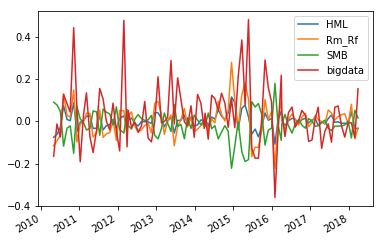

In [37]:
# df_X.describe()
df_X.plot()

In [38]:
X=df_X.values
# np.corrcoef(X,rowvar=False)
X

array([[-3.46651260e-02, -3.20187914e-02,  1.53152448e-02,
         1.53648701e-01],
       [-3.37249784e-02, -8.25495456e-02,  5.18962903e-02,
        -7.78727382e-02],
       [ 4.55922807e-02,  7.99189829e-02, -7.89890783e-02,
        -7.62966960e-03],
       [-1.41775680e-02, -1.32408609e-02, -7.27313242e-05,
        -7.46803954e-03],
       [-9.72382665e-03,  3.56566202e-02, -1.71855358e-02,
        -7.47342040e-02],
       [-9.49274058e-03,  3.07856384e-02, -2.27482976e-02,
        -2.06294264e-02],
       [-2.45364203e-03,  2.18513544e-02, -2.28729924e-02,
         7.20391634e-02],
       [-5.13550171e-03,  5.43971784e-03, -2.31955154e-02,
         6.60585329e-02],
       [ 2.92930158e-02,  3.82818740e-02, -4.34781200e-02,
        -9.87458529e-02],
       [ 1.32565771e-02,  5.31708646e-02, -3.37070063e-02,
        -1.24503036e-02],
       [-1.24095475e-02, -1.31129554e-02,  5.09679561e-03,
        -4.83338040e-02],
       [-4.10269122e-03, -8.96061903e-04, -6.28504901e-03,
      

In [39]:
#get_stocks_r 计算某个数组的股票的收益率Series
#index_date 为观察的数据周期中的日期
#stocks 为要计算的股票数组
#return_data 为总的回报率数据
#df_market_cap 为总的市值数据
def get_stocks_r(index_date,stocks,return_data,df_market_cap):
    s_r = pd.Series(index = index_date)
#     median_size,lmark,hmark=get_div_point(index_date,df_market_cap,btm)
    for date in index_date:
        total_return=0.0
        total_cap=0.0
        for stk in stocks:
            stock_date_cap=df_market_cap[stk][date]
            stock_date_return=return_data[stk][date]*stock_date_cap
            total_cap=total_cap+stock_date_cap
            total_return=total_return+stock_date_return

        s_r[date] = (total_return)/total_cap#每日回报率＝每日总回报/总市值
    return s_r

In [40]:
def get_y(s_y,Rf):
    y = np.array(s_y - Rf)
#     print(y)
    y=y[:data_count-1]
    YT = y.T
    return YT
# y=get_y(return_data_ydyl,Rf)

In [41]:
# str(concept('一带一路'))
arr_ydyl=['000022.XSHE', '000042.XSHE', '000065.XSHE', '000088.XSHE', '000090.XSHE', '000151.XSHE', '000157.XSHE', '000159.XSHE', '000400.XSHE', '000425.XSHE', '000498.XSHE', '000507.XSHE', '000528.XSHE', '000564.XSHE', '000582.XSHE', '000610.XSHE', '000617.XSHE', '000672.XSHE', '000680.XSHE', '000703.XSHE', '000777.XSHE', '000797.XSHE', '000852.XSHE', '000862.XSHE', '000877.XSHE', '000905.XSHE', '000928.XSHE', '000939.XSHE', '000978.XSHE', '600026.XSHG', '600028.XSHG', '600031.XSHG', '600068.XSHG', '600089.XSHG', '600105.XSHG', '600118.XSHG', '600125.XSHG', '600150.XSHG', '600170.XSHG', '600176.XSHG', '600179.XSHG', '600190.XSHG', '600202.XSHG', '600256.XSHG', '600279.XSHG', '600312.XSHG', '600317.XSHG', '600320.XSHG', '600339.XSHG', '600350.XSHG', '600368.XSHG', '600406.XSHG', '600425.XSHG', '600428.XSHG', '600449.XSHG', '600477.XSHG', '600487.XSHG', '600495.XSHG', '600509.XSHG', '600522.XSHG', '600528.XSHG', '600540.XSHG', '600580.XSHG', '600581.XSHG', '600583.XSHG', '600706.XSHG', '600717.XSHG', '600720.XSHG', '600778.XSHG', '600798.XSHG', '600801.XSHG', '600820.XSHG', '600888.XSHG', '600984.XSHG', '002040.XSHE', '600970.XSHG', '002047.XSHE', '002051.XSHE', '600017.XSHG', '600018.XSHG', '601872.XSHG', '601008.XSHG', '002135.XSHE', '601919.XSHG', '002146.XSHE', '601808.XSHG', '601857.XSHG', '601390.XSHG', '601866.XSHG', '002205.XSHE', '002207.XSHE', '601186.XSHG', '601668.XSHG', '002266.XSHE', '601766.XSHG', '601727.XSHG', '601989.XSHG', '002302.XSHE', '002307.XSHE', '002309.XSHE', '601618.XSHG', '601117.XSHG', '300011.XSHE', '002323.XSHE', '002353.XSHE', '601179.XSHG', '601106.XSHG', '002459.XSHE', '300090.XSHE', '300103.XSHE', '601018.XSHG', '002475.XSHE', '601028.XSHG', '002554.XSHE', '002738.XSHE', '601880.XSHG', '002524.XSHE', '300183.XSHE', '601789.XSHG', '300208.XSHE', '300262.XSHE', '601669.XSHG', '601800.XSHG', '603333.XSHG', '603308.XSHG', '300351.XSHE', '603111.XSHG', '600023.XSHG', '300523.XSHE', '300374.XSHE', '603969.XSHG', '603569.XSHG', '603338.XSHG', '603018.XSHG', '603169.XSHG', '002828.XSHE', '603036.XSHG', '603298.XSHG', '603966.XSHG', '603218.XSHG', '601228.XSHG', '600326.XSHG', '603588.XSHG', '603619.XSHG', '600219.XSHG', '300065.XSHE', '002742.XSHE', '600415.XSHG', '603871.XSHG', '300732.XSHE', '600338.XSHG', '600010.XSHG', '600039.XSHG', '601899.XSHG', '002800.XSHE', '601500.XSHG', '300589.XSHE']
if(data_type=="net"):
    arr_ydyl=concept('一带一路')
print('len(arr_ydyl)',len(arr_ydyl))

len(arr_ydyl) 157


In [42]:
# return_data_ydyl=None
# if(data_mode=="fast"):
#     return_data_ydyl=pd.read_csv("return_data_ydyl.csv",index_col=0)
#     return_data_ydyl=trans_index(return_data_ydyl)
# else:
# #     return_data_ydyl=get_return_data(index_date,arr_ydyl,df_price_data)
#     return_data_ydyl=get_stocks_r(index_date,arr_ydyl,return_data,df_market_cap)
return_data_ydyl=get_stocks_r(index_date,arr_ydyl,return_data,df_market_cap)
# return_data_ydyl.to_csv("return_data_ydyl.csv")
return_data_ydyl

2018-03-30   -0.028949
2018-02-28   -0.104921
2018-01-26    0.103772
2017-12-26   -0.019805
2017-11-24   -0.004320
2017-10-24    0.011195
2017-09-22   -0.003050
2017-08-22   -0.000913
2017-07-21    0.055499
2017-06-21    0.014318
2017-05-19   -0.054953
2017-04-19    0.032637
2017-03-17   -0.013705
2017-02-17    0.035753
2017-01-17    0.043298
2016-12-16    0.001903
2016-11-16    0.077130
2016-10-14    0.026541
2016-09-14    0.006522
2016-08-12    0.000897
2016-07-12    0.043105
2016-06-08   -0.006054
2016-05-06   -0.065076
2016-04-06    0.012142
2016-04-01    0.103728
2016-03-01    0.019193
2016-02-01   -0.223980
2015-12-31   -0.007369
2015-11-30   -0.030457
2015-10-30    0.098003
                ...   
2012-09-14   -0.007217
2012-08-14   -0.000178
2012-07-13   -0.055355
2012-06-13   -0.025102
2012-05-11    0.018046
2012-04-11    0.016584
2012-03-30   -0.072500
2012-02-29    0.041254
2012-01-20    0.063403
2011-12-20   -0.063282
2011-11-18    0.008638
2011-10-18   -0.021284
2011-09-16 

In [43]:
YT=get_y(return_data_ydyl,Rf)
X = sm.add_constant(X)
mod = regression.linear_model.OLS(YT, X).fit()
p = mod.params
print(p)
mod.summary()
#HML	Rm_Rf	SMB	bigdata

[-0.00591546  0.71357762 -0.04619573 -0.98545348 -0.10192201]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     185.7
Date:                Sun, 03 Jun 2018   Prob (F-statistic):           1.35e-42
Time:                        15:51:56   Log-Likelihood:                 211.68
No. Observations:                  95   AIC:                            -413.4
Df Residuals:                      90   BIC:                            -400.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.004     -1.573      0.119      -0.013       0.002
x1             0.7136      0.255      2.798      0.006       0.207       1.220
x2            -0.0462      0.189     -0.244      0.807      -0.422       0.329
x3            -0.9855      0.226     -4.355      0.000      -1.435      -0.536
x4            -0.1019      0.029     -3.539      0.001      -0.159      -0.045
==============================================================================
Omnibus:                       25.516   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.842
Skew:                           0.795   Prob(JB):                     6.22e-19
Kurtosis:                       7.319   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
#np.corrcoef(X)
# np.seterr(divide='ignore', invalid='ignore')
# np.corrcoef(X,rowvar=False)#终于调用成功了，原因时前面的X = sm.add_constant(X)改变了X，已经不是一个简单的3维数组啦，是4列了，而去第一列的数据是：1.00000000e+00所以报错了。
X
# np.corrcoef??

array([[ 1.00000000e+00, -3.46651260e-02, -3.20187914e-02,
         1.53152448e-02,  1.53648701e-01],
       [ 1.00000000e+00, -3.37249784e-02, -8.25495456e-02,
         5.18962903e-02, -7.78727382e-02],
       [ 1.00000000e+00,  4.55922807e-02,  7.99189829e-02,
        -7.89890783e-02, -7.62966960e-03],
       [ 1.00000000e+00, -1.41775680e-02, -1.32408609e-02,
        -7.27313242e-05, -7.46803954e-03],
       [ 1.00000000e+00, -9.72382665e-03,  3.56566202e-02,
        -1.71855358e-02, -7.47342040e-02],
       [ 1.00000000e+00, -9.49274058e-03,  3.07856384e-02,
        -2.27482976e-02, -2.06294264e-02],
       [ 1.00000000e+00, -2.45364203e-03,  2.18513544e-02,
        -2.28729924e-02,  7.20391634e-02],
       [ 1.00000000e+00, -5.13550171e-03,  5.43971784e-03,
        -2.31955154e-02,  6.60585329e-02],
       [ 1.00000000e+00,  2.92930158e-02,  3.82818740e-02,
        -4.34781200e-02, -9.87458529e-02],
       [ 1.00000000e+00,  1.32565771e-02,  5.31708646e-02,
        -3.37070063e-02

In [45]:
# df_bigdata_origin=pd.read_csv("bigdata.csv",encoding="gbk",index_col=0)
# df_bigdata_origin
# df_bigdata=pd.Series(df_bigdata_origin["收盘点位"],index=df_bigdata_origin.index,name="bigdata")
# # df_bigdata["close"]=df_bigdata_origin["收盘点位"]
# df_bigdata.index.name="index_date"
# df_bigdata.to_csv("bigdata_close.csv")
# df_bigdata=trans_index(df_bigdata)
# df_bigdata2=df_bigdata[df_bigdata.index.isin(index_date)]
# df_bigdata2.to_csv("bigdata_pure.csv")
# df_bigdata=pd.read_csv("bigdata_pure.csv",index_col=0,header=None)
# df_bigdata["test"]=df_bigdata_origin["收盘点位"]
# df_bigdata

In [46]:
# price_data=get_price_cs(data_starttime,data_endtime)#1944 rows × 3631 columns
# price_data

In [47]:
len(stocks)

3513

In [48]:
# price_data[stocks]
# price_data[not ]
# price_data[]
# np.all(np.any(price_data,axis=1))#==true
# price_data[1940:].groupby("603186.XSHG").size()#np.nan不参与计算，所以无法得出np.nan的个数
# ss=price_data["603186.XSHG"]
# type(ss[0])#np.nan!=NaN,  type(NaN)==numpy.float64
# ss[np.isnan(ss)]

In [49]:
# price_data.apply(lambda x:x)
# np.percentile([1,2,np.nan,4,5],40)
# price_data.dropna(axis=1,how='all') 
